# **TEAM NAME: performative males**

#1.Setup and Initialization

##1.1.Install Libraries

Installs required Python libray for modelling, machine learning, and deep learning

In [ ]:
!pip install torch transformers catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


##1.2.Import Libraries

Imports basic library, machine learning, deep learning, and modelling libraries, as well as utility modules.

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
import re
import os
import gc
import random
import json
import warnings
import math
import joblib
from copy import deepcopy

# Colab Specific
from google.colab import drive

# Progress Bars
from tqdm.auto import tqdm
tqdm.pandas()

# Text Processing
import unicodedata

# Machine Learning - General
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression, Ridge, HuberRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression
from scipy.optimize import nnls
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Deep Learning (PyTorch and Transformers)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW

# Gradient Boosting Libraries
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

##1.3.Configuration and Environment Setup

Sets up the display column (to show all columns), mount to GDrive, sets random seeds for reproducibility, and defines base and file path

In [ ]:
# set pd option to show all columns
pd.set_option('display.max_columns', None)

# Mount Google Drive to access files
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Please ensure you have authorized Google Colab to access your Drive.")

# seed for reproducibility
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the base path to project folder
BASE_PATH = "/content/drive/MyDrive/airnology/objqst_arnlgy/"
TRAIN_FILE = os.path.join(BASE_PATH, "train_df.parquet")
TEST_FILE = os.path.join(BASE_PATH, "test_df.parquet")

Mounted at /content/drive
Google Drive mounted successfully.


## 1.4.Data Loading

Loads the training and test datasets (from Parquet) and show displays of their structure

In [ ]:
print("\n Loading data... ")
try:
    train_df = pd.read_parquet(TRAIN_FILE)
    test_df = pd.read_parquet(TEST_FILE)

    print("Training data loaded successfully.")
    print(f"Shape: {train_df.shape}")
    print("Columns:", train_df.columns.tolist())
    print("\nTest data loaded successfully.")
    print(f"Shape: {test_df.shape}")
    print("Columns:", test_df.columns.tolist())

    print("\n--- Training Data Info ---")
    train_df.info()
    print("\n--- First 5 rows of Training Data ---")
    print(train_df.head())

except FileNotFoundError:
    print(f"ERROR: Files not found. Please check your BASE_PATH.")
    print(f"Attempted to load from: {TRAIN_FILE} and {TEST_FILE}")


=== 2. Loading data... ===
Training data loaded successfully.
Shape: (16572, 3)
Columns: ['id', 'text', 'lama hukuman (bulan)']

Test data loaded successfully.
Shape: (6666, 2)
Columns: ['id', 'text']

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16572 entries, 0 to 16571
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    16572 non-null  object
 1   text                  16572 non-null  object
 2   lama hukuman (bulan)  16572 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 388.5+ KB

--- First 5 rows of Training Data ---
          id                                               text  \
0  doc_13590  hkama\nahkamah Agung Repub\nahkamah Agung Repu...   
1  doc_14914  hkama\nahkamah Agung Repub\nahkamah Agung Repu...   
2  doc_21900  hkama\nahkamah Agung Repub\nahkamah Agung Repu...   
3  doc_14859  hkama\nahkamah Agung Repub\nahkamah Agu

#2.Data Cleaning and Preprocessing

##2.1.Outlier Handling

Removes extreme oulier values (e.g there is a "life sentence" coded as 88888) from the training data to prevent model distortion.

In [ ]:
if not train_df.empty:
    print("\n Handling Outliers... ")
    # The 'life sentence' value of 88888 is a significant outlier. With only one sample in the training set, it's impossible to train a mode to predict it. We will remove it to prevent it from skewing the model.
    life_sentence_rows = train_df[train_df['lama hukuman (bulan)'] == 88888].shape[0]
    if life_sentence_rows > 0:
        print(f"Found {life_sentence_rows} row(s) with life sentence (88888). Removing it/them.")
        train_df = train_df[train_df['lama hukuman (bulan)'] != 88888].reset_index(drop=True)
        print(f"New training data shape: {train_df.shape}")
    else:
        print("No life sentence rows (88888) found in the training data.")


=== 3. Handling Outliers... ===
Found 1 row(s) with life sentence (88888). Removing it/them.
New training data shape: (16571, 3)


##2.2.Text Cleaning

Defines and applies a series of regular expressions (regex) and function to clean and normalize the text data, removing boilerplate, normalizing numbers, and standardizing for better formatting. Then also verifies cleaning result, saves cleaned data, strips newlines, normalizes spaces, and drop the original text columns for efficiency

In [ ]:
# Regex for whitespace normalization
NLWS_RE = re.compile(r'[\n\r\t]+')
SPACE_RE = re.compile(r'\s+')

# Regex for matching boilerplate blocks (anchored to common section headers/footers)
# anchors keep deletions bounded
ANCHOR = r'(?:halaman\s+\d+|putusan\s+nomor|pengadilan|menimbang|mengadili|tuntutan|dakwaan|majelis(?:\s+hakim)?|$)'
BLOCK_COMBINED_RE = re.compile(
    r'(?is)(?:'
    r'pelaksanaan\s+fungsi\s+peradilan'
    r'|transparansi\s+dan\s+akuntabilitas'
    r'|\bdisclaimer\b[\s:,-]*'
    r'|kepaniteraan\s+mahkamah\s+agung\s+republik\s+indonesia\s+berusaha\s+untuk\s+selalu\s+mencantumkan\s+informasi\s+paling\s+kini'
    r').+?(?=' + ANCHOR + r')'
)

# Regex for matching boilerplate lines (multiline mode)
LINE_COMBINED_RE = re.compile(
    r'(?im)^.*pelaksanaan fungsi peradilan.*$|'
    r'^.*transparansi dan akuntabilitas.*$|'
    r'^.*dalam hal anda menemukan inakurasi.*$|'
    r'^.*kepaniteraan@mahkamahagung\.go\.id.*$|'
    r'^\s*telp\s*:.*$|'
    r'^\s*halaman\s+\d+(?:\s*dari\s+\d+)?\s*.*$|'
    r'^.*direktori putusan.*$|'
    r'^\s*hkama\s*$|'
    r'^\s*ahkamah\s+agung\s+repub.*$|'
    r'^\s*mahkamah\s+agung\s+repub.*$|'
    r'^\s*ahkamah\s+agung\s+republik\s+indonesia\s*$|'
    r'^\s*mahkamah\s+agung\s+republik\s+indonesia\s*$|'
    r'^\s*mah\s+agung\s+republik\s+indonesia\s*$|'
    r'^\s*blik\s+indonesi[a]?\s*$|'
    r'^\s*disclaimer\s*:?\s*$'
)

# Regex for specific text pattern normalization
SPACED_LETTERS_RE = re.compile(r'(?<![A-Za-z])(?:[A-Za-z]\s){2,}[A-Za-z](?![A-Za-z])') # "p u t u s a n" -> "putusan"
DIGIT_PAREN_WORD_RE = re.compile(r'\b(\d+)\s*\(\s*[a-zA-Z]+\s*\)') # "7 (tujuh)" -> "7"
DECIMAL_COMMA_RE = re.compile(r'(\d+),(\d+)') # Decimal comma -> dot
RP_AMOUNT_RE = re.compile(r'(?i)\brp\.?\s*([0-9\.\,]+)') # Rupiah normalization -> "rp 1500000"

# List of regex patterns and replacements for common UU citations
UU_NORMALIZERS = [
    (re.compile(r'(?i)undang-undang\s+republik\s+indonesia\s+nomor'), 'uu no'),
    (re.compile(r'(?i)undang-undang\s+ri\s+nomor'), 'uu no'),
    (re.compile(r'(?i)undang-undang\s+nomor'), 'uu no'),
]

# Substring triggers for quick check before running heavy regex patterns
TRIGGERS = (
    "disclaimer", "pelaksanaan fungsi peradilan", "transparansi dan akuntabilitas",
    "kepaniteraan", "@mahkamahagung.go.id", "telp", "halaman", "direktori putusan",
    "mahkamah agung", "ahkamah", "hkama", "blik indonesi"
)

# Helper function for normalizing Rupiah amounts
def _normalize_rp(m):
    s = m.group(1).replace('.', '').replace(',', '')
    return f'rp {s}' if s else m.group(0)

# Helper function for unspacing letters
def _unspace_letters(s: str) -> str:
    return SPACED_LETTERS_RE.sub(lambda m: m.group(0).replace(' ', ''), s)

# Main cleaning function for a single text string
def clean_one(text: str) -> str:
    if not isinstance(text, str) or not text:
        return ""

    # Unicode normalize and lowercase early
    text = unicodedata.normalize('NFKC', text).lower()

    # Fast skip: only run heavy patterns if any trigger substring is present
    needs_block = any(t in text for t in TRIGGERS)

    if needs_block:
        # Block-level removal (global)
        text = BLOCK_COMBINED_RE.sub(' ', text)
        # Line-level removal (global)
        text = LINE_COMBINED_RE.sub(' ', text)

    # Collapse spaced headings like "p u t u s a n"
    text = _unspace_letters(text)

    # UU wording normalization
    for pat, rep in UU_NORMALIZERS:
        text = pat.sub(rep, text)

    # Money & decimals normalization
    text = RP_AMOUNT_RE.sub(_normalize_rp, text)
    text = DECIMAL_COMMA_RE.sub(r'\1.\2', text)

    # Numbers like "7 (tujuh)" -> "7"
    text = DIGIT_PAREN_WORD_RE.sub(r'\1', text)

    # Normalize whitespace
    text = NLWS_RE.sub(' ', text)
    return SPACE_RE.sub(' ', text).strip()

# Function to apply cleaning to a dataframe in chunks
def clean_dataframe_in_chunks(df, text_col, out_col, chunk_size=2000, desc="Cleaning"):
    n = len(df)
    out = []
    for start in tqdm(range(0, n, chunk_size), desc=desc):
        end = min(start + chunk_size, n)
        # List comprehension for faster application
        batch = [clean_one(x) for x in df[text_col].iloc[start:end].tolist()]
        out.extend(batch)
        # Free batch references early
        del batch
        gc.collect()
    df[out_col] = pd.Series(out, index=df.index)
    return df

if not train_df.empty and not test_df.empty:
    print("\nApplying cleaning functions to train and test dataframes (chunked)...")

    # You can tune chunk_size based on your RAM/CPU
    clean_dataframe_in_chunks(train_df, 'text', 'cleaned_text', chunk_size=1500, desc="Train clean")
    clean_dataframe_in_chunks(test_df,  'text', 'cleaned_text', chunk_size=1500, desc="Test clean")

    print("Cleaning complete.")

    # Quick verification
    print("\n--- Verifying the cleaning process ---")
    i = 0
    if len(train_df) > i:
        print(f"\n--- ORIGINAL (first 400 chars) ---\n{train_df['text'].iloc[i][:400]}")
        print(f"\n--- CLEANED  (first 400 chars) ---\n{train_df['cleaned_text'].iloc[i][:400]}")

    # Save cleaned dataframes (optional, but good practice)
    CLEANED_TRAIN_FILE = os.path.join(BASE_PATH, "train_df_cleaned.parquet")
    CLEANED_TEST_FILE = os.path.join(BASE_PATH, "test_df_cleaned.parquet")
    train_df.to_parquet(CLEANED_TRAIN_FILE, index=False)
    test_df.to_parquet(CLEANED_TEST_FILE, index=False)
    print(f"\nSaving cleaned dataframes to Parquet...")
    print(f"Cleaned training data saved to: {CLEANED_TRAIN_FILE}")
    print(f"Cleaned test data saved to: {CLEANED_TEST_FILE}")

else:
    print("\nSkipping cleaning and saving as dataframes are empty.")


# Function to strip newlines and normalize spaces
def strip_newlines(text):
    if not isinstance(text, str):
        return ""
    # Replace all newlines and tabs with space
    text = re.sub(r'[\n\r\t]+', ' ', text)
    # Normalize spaces
    return re.sub(r'\s+', ' ', text).strip()

# Apply to both train and test cleaned_text columns
train_df['cleaned_text'] = train_df['cleaned_text'].apply(strip_newlines)
test_df['cleaned_text'] = test_df['cleaned_text'].apply(strip_newlines)

# Drop the original raw text column
train_df.drop(columns=['text'], inplace=True)
test_df.drop(columns=['text'], inplace=True)


=== 4. Defining Text Cleaning Functions (optimized) ===

Applying cleaning functions to train and test dataframes (chunked)...


Test clean: 100%|██████████| 5/5 [04:13<00:00, 50.74s/it]


Cleaning complete.

--- Verifying the cleaning process ---

--- ORIGINAL (first 400 chars) ---
hkama
ahkamah Agung Repub
ahkamah Agung Republik Indonesia
mah Agung Republik Indonesia
blik Indonesi
Direktori Putusan Mahkamah Agung Republik Indonesia

Halaman 1 dari 17 halaman Putusan Nomor   :  
Nama lengkap  
: JULIANTI LAHINTA alias JURNI; 
Nomor Identitas 
: 7172021303002002; 
Tempat lahir  
 
 
: Bitung; 
Umur/Tanggal lahir : 39 Tahun / 16 Maret 1985; 
Jenis Kelamin  
  : Perempuan; 
Keb

--- CLEANED  (first 400 chars) ---
nama lengkap : julianti lahinta alias jurni; nomor identitas : 7172021303002002; tempat lahir : bitung; umur/tanggal lahir : 39 tahun / 16 maret 1985; jenis kelamin : perempuan; kebangsaaan/ kewarganegaraan : indonesia; tempat tinggal : kelurahan girian weru satu kec. girian kota bitung; agama : islam; pekerjaan : mengurus rumah tangga; terdakwa ditahan dalam tahanan tahanan rutan oleh : - penyidi

Saving cleaned dataframes to Parquet...
Cleaned training data save

#3.Feature Engineering

##3.1.Base Engineered Features

Extracts structured features from the cleaned text, such as demographics, legal articles numbers, severity indicators prosecutor demans, and text statistics

In [ ]:
tqdm.pandas()

# ==============================================================================
# === 1. FEATURE EXTRACTION FUNCTIONS ==========================================
# ==============================================================================

# --- A. Foundational Features (Demographics, etc.) ---

def convert_word_to_number(word):
    """Converts Indonesian number words (1-12) to integers."""
    word_map = {
        'satu': 1, 'dua': 2, 'tiga': 3, 'empat': 4, 'lima': 5, 'enam': 6,
        'tujuh': 7, 'delapan': 8, 'sembilan': 9, 'sepuluh': 10,
        'sebelas': 11, 'dua belas': 12
    }
    return word_map.get(str(word).lower(), -1)

def extract_demographics(text):
    """Extracts age, gender, and job."""
    features = {
        'age': -1,
        'gender': -1, # 0: Perempuan, 1: Laki-laki
        'job_category': 'Unknown'
    }
    # Age
    age_match = re.search(r'umur/tanggal lahir\s*:\s*(\d+)\s*tahun', text, re.IGNORECASE)
    if age_match:
        features['age'] = int(age_match.group(1))
    # Gender
    if re.search(r'jenis kelamin\s*:\s*(laki-laki|laki – laki)', text, re.IGNORECASE):
        features['gender'] = 1
    elif re.search(r'jenis kelamin\s*:\s*perempuan', text, re.IGNORECASE):
        features['gender'] = 0
    # Job
    job_match = re.search(r'pekerjaan\s*:\s*([\w\s]+?)\n', text, re.IGNORECASE)
    if job_match:
        job = job_match.group(1).strip().lower()
        if 'negeri' in job or 'pns' in job: features['job_category'] = 'Government'
        elif 'wiraswasta' in job: features['job_category'] = 'Business'
        elif 'buruh' in job or 'lepas' in job: features['job_category'] = 'Laborer'
        elif 'petani' in job or 'nelayan' in job : features['job_category'] = 'Agriculture'
        else: features['job_category'] = 'Other'
    return features

# --- B. Tier 1: Critical Severity and Legal Features ---

def extract_quantitative_severity(text):
    """Extracts critical numerical values like drug weights and financial loss."""
    features = {
        'drug_weight_gram': 0.0,
        'kerugian_rp': 0
    }
    text_lower = text.lower()
    # a) Extract drug weight (netto > bruto > kotor)
    patterns = [
        r'(?:berat bersih|netto)\s*[:\s]*([\d.,]+)\s*gram',
        r'seberat\s*([\d.,]+)\s*gram',
        r'(?:berat bruto|kotor)\s*[:\s]*([\d.,]+)\s*gram'
    ]
    for pat in patterns:
        match = re.search(pat, text_lower)
        if match:
            try:
                weight_str = match.group(1).replace(',', '.')
                features['drug_weight_gram'] = float(weight_str)
                break
            except (ValueError, IndexError):
                continue
    # b) Extract financial loss (kerugian)
    match = re.search(r'kerugian\s*(?:sebesar|sejumlah|sekitar)?\s*rp\s*\.?\s*([\d.,]+)', text_lower)
    if match:
        try:
            kerugian_str = match.group(1).replace('.', '').replace(',', '')
            features['kerugian_rp'] = int(kerugian_str)
        except (ValueError, IndexError):
            pass
    return features

def extract_high_resolution_pasal(text):
    """Deconstructs the primary legal charge into granular components."""
    features = {
        'law_family': 'unknown',
        'pasal_utama': -1,
        'pasal_ayat': -1,
        'is_jo_pasal_55': 0, # Acting together
    }
    text_lower = text.lower()
    # a) Determine Law Family
    if 'narkotika' in text_lower: features['law_family'] = 'Narkotika'
    elif 'perlindungan anak' in text_lower: features['law_family'] = 'Perlindungan_Anak'
    elif 'kuhp' in text_lower: features['law_family'] = 'KUHP'
    elif 'kesehatan' in text_lower: features['law_family'] = 'Kesehatan'
    elif 'lalu lintas' in text_lower: features['law_family'] = 'Lalu_Lintas'

    # b) Extract primary article from the final verdict/amar section for highest accuracy
    amar_match = re.search(r'mengingat,(.*?)(?:mengadili|menjatuhkan pidana)', text_lower, re.DOTALL)
    search_text = amar_match.group(1) if amar_match else text_lower

    pasal_match = re.search(r'pasal\s+(\d+)\s*(?:ayat\s*\((\d+)\))?', search_text)
    if pasal_match:
        features['pasal_utama'] = int(pasal_match.group(1))
        if pasal_match.group(2):
            features['pasal_ayat'] = int(pasal_match.group(2))

    # c) Check for co-conspiracy article
    if 'jo.\s*pasal\s+55' in text_lower:
        features['is_jo_pasal_55'] = 1
    return features

def extract_robust_prosecutor_demands(text):
    """Robustly extracts the prosecutor's demand (Tuntutan)."""
    demands = {
        'tuntutan_sentence_months': -1,
        'tuntutan_fine_rp': 0,
        'tuntutan_subsidiary_months': 0
    }
    demand_section_match = re.search(r'(?:tuntutan pidana|menuntut|requisitoir).*?sebagai berikut\s*:(.*?)(?:setelah mendengar|menimbang)', text, re.DOTALL | re.IGNORECASE)
    if not demand_section_match:
        return demands
    demand_text = demand_section_match.group(1).lower()

    # Sentence Demand
    sentence_match = re.search(r'pidana penjara.*?selama\s+(?:([\d\s]+)\s*\((.*?)\)\s*)?([\d\w\s]+?)\s+(tahun|bulan)', demand_text)
    if sentence_match:
        *_, duration_str, unit = sentence_match.groups()
        try:
            num_val = re.search(r'(\d+)', duration_str)
            duration = int(num_val.group(1)) if num_val else convert_word_to_number(duration_str.strip())
            if duration != -1:
                demands['tuntutan_sentence_months'] = duration * 12 if 'tahun' in unit else duration
        except: pass

    # Fine Demand
    fine_match = re.search(r'denda\s+(?:sebanyak|sebesar)\s+rp\s*\.?\s*([\d.,]+)', demand_text)
    if fine_match:
        try:
            fine_str = fine_match.group(1).replace('.', '').replace(',', '')
            demands['tuntutan_fine_rp'] = int(fine_str)
        except: pass

    # Subsidiary Demand
    subs_match = re.search(r'subsidair\s+([\d\w\s]+?)\s+(bulan|tahun)', demand_text)
    if subs_match:
        try:
            duration_str, unit = subs_match.groups()
            num_val = re.search(r'(\d+)', duration_str)
            duration = int(num_val.group(1)) if num_val else convert_word_to_number(duration_str.strip())
            if duration != -1:
                demands['tuntutan_subsidiary_months'] = duration * 12 if 'tahun' in unit else duration
        except: pass
    return demands

# --- C. Tier 2: Rationale and Text Statistics ---

def extract_expanded_rationale_flags(text):
    """Extracts keyword flags for mitigating and aggravating factors and adds counts."""
    agg_text_match = re.search(r'keadaan(-keadaan)? yang memberatkan\s*:(.*?)(?:keadaan(-keadaan)? yang meringankan|menimbang)', text, re.DOTALL | re.IGNORECASE)
    mit_text_match = re.search(r'keadaan(-keadaan)? yang meringankan\s*:(.*?)(?:menimbang|memperhatikan|mengingat)', text, re.DOTALL | re.IGNORECASE)
    aggravating_text = agg_text_match.group(2).lower() if agg_text_match else ''
    mitigating_text = mit_text_match.group(2).lower() if mit_text_match else ''

    flags = {
        'flag_sopan': 1 if 'sopan' in mitigating_text else 0,
        'flag_menyesal': 1 if 'menyesali' in mitigating_text else 0,
        'flag_mengakui': 1 if 'mengakui' in mitigating_text or 'berterus terang' in mitigating_text else 0,
        'flag_belum_pernah_hukum': 1 if 'belum pernah dihukum' in mitigating_text else 0,
        'flag_tulang_punggung': 1 if 'tulang punggung' in mitigating_text else 0,
        'flag_residivis': 1 if 'pernah dihukum' in aggravating_text or 'residivis' in aggravating_text else 0,
        'flag_berbelit': 1 if 'berbelit-belit' in aggravating_text else 0,
        'flag_anti_pemerintah': 1 if 'tidak mendukung program pemerintah' in aggravating_text else 0,
    }
    flags['num_meringankan'] = flags['flag_sopan'] + flags['flag_menyesal'] + flags['flag_mengakui'] + flags['flag_belum_pernah_hukum'] + flags['flag_tulang_punggung']
    flags['num_memberatkan'] = flags['flag_residivis'] + flags['flag_berbelit'] + flags['flag_anti_pemerintah']
    return flags

def extract_text_stats(text):
    """Extracts basic statistical features from the text."""
    text_lower = text.lower()
    return {
        'char_count': len(text),
        'word_count': len(text.split()),
        'saksi_count': text_lower.count('saksi'),
        'terdakwa_mentions': text_lower.count('terdakwa'),
    }

# ==============================================================================
# === 2. MAIN FEATURE ENGINEERING ORCHESTRATOR =================================
# ==============================================================================

def engineer_rule_based_features(df, text_column='cleaned_text'):
    """Applies all feature engineering functions to the dataframe."""
    df[text_column] = df[text_column].astype(str).fillna('')
    features_list = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Engineering Features"):
        text = row[text_column]
        all_row_features = {}
        all_row_features.update(extract_demographics(text))
        all_row_features.update(extract_quantitative_severity(text))
        all_row_features.update(extract_high_resolution_pasal(text))
        all_row_features.update(extract_robust_prosecutor_demands(text))
        all_row_features.update(extract_expanded_rationale_flags(text))
        all_row_features.update(extract_text_stats(text))
        features_list.append(all_row_features)

    features_df = pd.DataFrame(features_list, index=df.index)

    # One-hot encode categorical features
    features_df = pd.get_dummies(features_df, columns=['job_category', 'law_family'], prefix=['job', 'law'])

    return pd.concat([df, features_df], axis=1)

def add_log_and_binary_features(df):
    """Creates log-transformed and binary indicator features."""
    print("Creating log-transform and binary flag features...")
    # Log transform skewed numerical features
    for col in ['kerugian_rp', 'tuntutan_fine_rp', 'drug_weight_gram']:
        df[f'{col}_log'] = np.log1p(df[col])

    # Create binary flags for missing vs. zero
    df['has_kerugian'] = (df['kerugian_rp'] > 0).astype(int)
    df['has_fine_demand'] = (df['tuntutan_fine_rp'] > 0).astype(int)
    df['has_drug_weight'] = (df['drug_weight_gram'] > 0).astype(int)
    df['demand_was_made'] = (df['tuntutan_sentence_months'] != -1).astype(int)

    return df

def create_interaction_features(df):
    """Creates interaction and ratio features."""
    print("Creating interaction and ratio features...")
    # Replace -1 with a neutral value (like 0) before creating ratios
    demand_filled = df['tuntutan_sentence_months'].replace(-1, 0)

    # Add 1 to denominators to avoid division by zero
    df['age_x_recidivist'] = df['age'] * df['flag_residivis']
    df['fine_per_loss_ratio'] = df['tuntutan_fine_rp'] / (df['kerugian_rp'] + 1)

    # Ratio of demand to drug weight or financial loss.
    df['demand_per_drug_gram_ratio'] = demand_filled / (df['drug_weight_gram'] + 1e-6)
    df['demand_per_kerugian_ratio'] = demand_filled / (df['kerugian_rp'] + 1)

    return df

# ==============================================================================
# === 3. EXECUTION SCRIPT ======================================================
# ==============================================================================


# --- Apply Feature Engineering Pipeline ---
print("Processing training data...")
train_df_fe = engineer_rule_based_features(train_df)
train_df_fe = add_log_and_binary_features(train_df_fe)
train_df_fe = create_interaction_features(train_df_fe)

print("\nProcessing test data...")
test_df_fe = engineer_rule_based_features(test_df)
test_df_fe = add_log_and_binary_features(test_df_fe)
test_df_fe = create_interaction_features(test_df_fe)

print("\n--- Feature Engineering Complete ---")
print(f"Shape of final training data: {train_df_fe.shape}")
print(f"Shape of final test data: {test_df_fe.shape}")
print("\n--- Sample of Final Training Data with New Features ---")
display(train_df_fe.head())
print("\n--- Columns Created ---")
display(train_df_fe.columns)

<>:119: SyntaxWarning: invalid escape sequence '\s'
<>:119: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3759346500.py:119: SyntaxWarning: invalid escape sequence '\s'
  if 'jo.\s*pasal\s+55' in text_lower:


Processing training data...


Engineering Features: 100%|██████████| 16571/16571 [02:33<00:00, 108.04it/s]


Creating log-transform and binary flag features...
Creating interaction and ratio features...

Processing test data...


Engineering Features: 100%|██████████| 6666/6666 [01:04<00:00, 103.72it/s]


Creating log-transform and binary flag features...
Creating interaction and ratio features...

--- Feature Engineering Complete ---
Shape of final training data: (16571, 45)
Shape of final test data: (6666, 44)

--- Sample of Final Training Data with New Features ---
          id  lama hukuman (bulan)  \
0  doc_13590                    10   
1  doc_14914                    60   
2  doc_21900                    18   
3  doc_14859                    72   
4  doc_10962                    60   

                                        cleaned_text  age  gender  \
0  nama lengkap : julianti lahinta alias jurni; n...   39       0   
1  putusan nomor : 1. nama lengkap : lukas regoy ...   -1       1   
2  acara pemeriksaan biasa pada peradilan tingkat...   33       1   
3  1. nama lengkap : daimon david mamanua ; 2. te...   32       1   
4  1. nama lengkap : samsul afrizal bin johar alm...   40       1   

   drug_weight_gram  kerugian_rp  pasal_utama  pasal_ayat  is_jo_pasal_55  \
0          

##3.2.Pasal Features

###3.2.1.Spot All Pasal in Dataset

Extracts all unique legal article (Pasal) numbers mentioned explicitly in the dataset

In [ ]:
print(" Extracting Unique Pasal Numbers from the Entire Dataset ")

# Combine 'cleaned_text' from both training and testing sets
all_dakwaan_text = pd.concat([
    train_df_fe['cleaned_text'],
    test_df_fe['cleaned_text']
]).dropna().astype(str)

# Use regex to find all occurrences of 'pasal' followed by digits
all_pasal_numbers = all_dakwaan_text.str.findall(r'pasal\s*(\d+)').explode()

# Get the unique, sorted list of all Pasal numbers
unique_pasal_list = sorted(all_pasal_numbers.dropna().unique().astype(int))

print(f"\nFound {len(unique_pasal_list)} unique Pasal numbers in dataset.")

# Cast to standard integers for cleaner output
print("These are all the pasal that need to be researched: ")
print([int(p) for p in unique_pasal_list])

 Extracting Unique Pasal Numbers from the Entire Dataset 

Found 504 unique Pasal numbers in dataset.
These are all the pasal that need to be researched: 
[1, 2, 2, 3, 3, 4, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 18

###3.2.2.Define Max Sentence for each Pasal

Maps each Pasal that found in dataset into its maximum legal sentence based on Indonesian laws

In [ ]:
LEGAL_MAX_SENTENCE = {
    '1': 0,      # KUHP: Aturan Umum - Asas Legalitas
    '2': 240,    # UU Tipikor: Merugikan keuangan negara (max 20 th)
    '3': 240,    # UU Tipikor: Menyalahgunakan kewenangan (max 20 th)
    '4': 0,      # KUHP: Aturan Umum
    '5': 60,     # UU Tipikor: Menyuap pegawai negeri (max 5 th)
    '6': 240,    # UU Tipikor: Menyuap hakim (max 20 th)
    '7': 84,     # UU Tipikor: Pemborong curang (max 7 th)
    '8': 180,    # UU Tipikor: Penggelapan dalam jabatan (max 15 th)
    '9': 60,     # UU Tipikor: Pemalsuan buku (max 5 th)
    '10': 120,   # UU Tipikor: Merintangi penyidikan (max 10 th)
    '11': 60,    # UU Tipikor: Gratifikasi (max 5 th)
    '12': 999,   # UU Tipikor: Gratifikasi kepada hakim/advokat (seumur hidup)
    '13': 999,   # UU Tipikor: Suap aktif kepada hakim/advokat (seumur hidup)
    '14': 0,     # KUHP: Aturan Umum - Pidana bersyarat
    '15': 999,   # UU Tipikor: Permufakatan jahat (sama dengan pidana pokok, diambil nilai tertinggi)
    '16': 0,     # KUHP: Aturan Umum - Persiapan
    '17': 0,     # KUHP: Aturan Umum - Percobaan
    '18': 16,    # KUHP: Pidana kurungan (max 1 th 4 bln)
    '19': 0,     # KUHP: Aturan Umum
    '20': 60,    # UU Tipikor: Menghalangi akses informasi (max 5 th)
    '21': 144,   # UU Tipikor: Saksi tidak beri keterangan (max 12 th)
    '22': 0,     # KUHAP: Aturan Acara - Jenis penahanan
    '23': 0,     # KUHP: Aturan Umum
    '24': 0,     # KUHP: Aturan Umum
    '25': 0,     # KUHP: Aturan Umum
    '26': 0,     # KUHP: Aturan Umum
    '27': 72,    # UU ITE: Konten ilegal (asusila, judi) (max 6 th)
    '28': 72,    # UU ITE: Ujaran kebencian/berita bohong (max 6 th)
    '29': 48,    # UU ITE: Pengancaman (max 4 th)
    '30': 8,     # KUHP: Pidana denda & kurungan pengganti (max 8 bln)
    '31': 36,    # UU Tipikor: Saksi tidak penuhi panggilan (max 3 th)
    '32': 0,     # KUHP: Aturan Umum
    '33': 0,     # KUHP: Aturan Umum
    '34': 0,     # KUHP: Aturan Umum
    '35': 0,     # KUHP: Aturan Umum - Pencabutan hak
    '36': 180,   # UU Mata Uang: Mengedarkan uang palsu (max 15 th)
    '37': 0,     # KUHP: Aturan Umum
    '38': 0,     # KUHP: Aturan Umum
    '39': 0,     # KUHP: Aturan Umum
    '40': 0,     # KUHP: Aturan Umum
    '41': 12,    # UU KUHP Baru: Perzinaan (max 1 th)
    '42': 84,    # RUU KUHP: Kesesatan (max 7 th)
    '43': 0,     # KUHP: Aturan Umum
    '44': 0,     # KUHP: Aturan Umum - Tidak mampu bertanggung jawab
    '45': 0,     # KUHP: Aturan Umum - Anak-anak
    '46': 0,     # KUHP: Aturan Umum
    '47': 0,     # KUHP: Aturan Umum
    '48': 0,     # KUHP: Aturan Umum - Daya paksa
    '49': 0,     # KUHP: Aturan Umum - Pembelaan terpaksa
    '50': 0,     # KUHP: Aturan Umum - Perintah UU
    '51': 0,     # KUHP: Aturan Umum - Perintah jabatan
    '52': 0,     # KUHP: Aturan Umum - Pemberatan karena jabatan
    '53': 180,   # KUHP: Percobaan kejahatan (max 15 th jika pidana pokok mati/seumur hidup)
    '54': 0,     # KUHP: Percobaan pelanggaran tidak dipidana
    '55': 0,     # KUHP: Aturan Umum - Penyertaan
    '56': 0,     # KUHP: Aturan Umum - Pembantuan
    '57': 180,   # KUHP: Pembantuan kejahatan (max 15 th jika pidana pokok mati/seumur hidup)
    '58': 0,     # RUU KUHP: Perubahan putusan
    '59': 0,     # KUHP: Aturan Umum - Korporasi
    '60': 0,     # KUHP: Aturan Umum
    '61': 0,     # KUHP: Aturan Umum
    '62': 60,    # UU Perlindungan Konsumen: Melanggar larangan (max 5 th)
    '63': 0,     # KUHP: Aturan Umum - Concursus idealis
    '64': 0,     # KUHP: Aturan Umum - Perbuatan berlanjut
    '65': 0,     # KUHP: Aturan Umum - Concursus realis
    '66': 0,     # RUU KUHP: Pidana Tambahan
    '67': 0,     # KUHP: Aturan Umum
    '68': 0,     # KUHP: Aturan Umum
    '69': 0,     # KUHAP: Aturan Acara - Hak penasihat hukum
    '70': 0,     # KUHP: Aturan Umum
    '71': 0,     # KUHP: Aturan Umum
    '72': 0,     # KUHP: Aturan Umum - Pengaduan
    '73': 48,    # UU No. 73/1958: Menodai bendera/lambang negara (max 4 th)
    '74': 0,     # KUHP: Aturan Umum
    '75': 120,   # UU Kesehatan: Aborsi ilegal (max 10 th)
    '76': 180,   # UU Perlindungan Anak: Larangan kekerasan (merujuk ke Pasal 80, max 15 th)
    '77': 60,    # UU Perlindungan Anak: Diskriminasi terhadap anak (max 5 th)
    '78': 0,     # KUHP: Aturan Umum - Daluwarsa
    '79': 0,     # KUHP: Aturan Umum - Daluwarsa
    '80': 180,   # UU Perlindungan Anak: Kekerasan terhadap anak (max 15 th jika mati)
    '81': 180,   # UU Perlindungan Anak: Persetubuhan terhadap anak (max 15 th)
    '82': 180,   # UU Perlindungan Anak: Pencabulan terhadap anak (max 15 th)
    '83': 0,     # KUHP: Aturan Umum
    '84': 120,   # UU Perikanan: Penggunaan alat/bahan terlarang (max 10 th)
    '85': 120,   # UU Perikanan: Kapal ikan asing tanpa izin (max 10 th)
    '86': 60,    # UU PPMI: Menempatkan PMI secara tidak sah (max 5 th)
    '87': 32,    # KUHPM: Desersi waktu damai (max 2 th 8 bln)
    '88': 0,     # KUHP: Aturan Umum
    '89': 0,     # KUHP: Aturan Umum - Definisi kekerasan
    '90': 0,     # KUHP: Aturan Umum - Definisi luka berat
    '91': 0,     # KUHP: Aturan Umum
    '92': 120,   # UU Perikanan: Pelanggaran SIPI/SIKPI (max 10 th)
    '93': 0,     # KUHP: Aturan Umum
    '94': 0,     # RUU KUHP: Merusak tempat ibadah
    '95': 0,     # KUHAP: Aturan Acara - Ganti rugi
    '96': 0,     # UU KUHP Baru: Pemenuhan kewajiban adat
    '97': 0,     # KUHAP: Aturan Acara - Rehabilitasi
    '98': 0,     # KUHP: Aturan Umum
    '99': 0,     # KUHP: Aturan Umum
    '100': 120,  # KUHP Baru: Pidana mati dengan masa percobaan 10 tahun
    '101': 999,  # KUHP Baru: Komutasi pidana mati menjadi seumur hidup
    '102': 120,  # UU Kepabeanan: Penyelundupan impor (max 10 th)
    '103': 96,   # UU Kepabeanan: Memberi keterangan tidak benar (max 8 th)
    '104': 999,  # KUHP: Makar membunuh Presiden (pidana mati/seumur hidup)
    '105': 0,    # KUHP: Tidak ada pasal ini, kemungkinan salah ketik dari 104 atau 106
    '106': 999,  # KUHP: Makar memisahkan diri dari NKRI (pidana seumur hidup)
    '107': 240,  # KUHP: Makar menggulingkan pemerintah (pemimpin, max 20 th)
    '108': 240,  # KUHP: Pemberontakan (pemimpin, max 20 th)
    '109': 0,    # KUHP: Tidak ada pasal pidana
    '110': 999,  # KUHP: Permufakatan jahat makar (sama dengan pidana pokok)
    '111': 144,  # UU Narkotika: Memiliki Narkotika Gol I (max 12 th)
    '112': 144,  # UU Narkotika: Memiliki Narkotika Gol I non-tanaman (max 12 th)
    '113': 180,  # UU Narkotika: Produksi Narkotika Gol I (max 15 th)
    '114': 240,  # UU Narkotika: Peredaran Narkotika Gol I (max 20 th)
    '115': 144,  # UU Narkotika: Kurir Narkotika Gol I (max 12 th)
    '116': 180,  # UU Narkotika: Penggunaan terhadap orang lain Gol I (max 15 th)
    '117': 120,  # UU Narkotika: Memiliki Narkotika Gol II (max 10 th)
    '118': 144,  # UU Narkotika: Produksi Narkotika Gol II (max 12 th)
    '119': 144,  # UU Narkotika: Peredaran Narkotika Gol II (max 12 th)
    '120': 120,  # UU Narkotika: Kurir Narkotika Gol II (max 10 th)
    '121': 144,  # UU Narkotika: Penggunaan terhadap orang lain Gol II (max 12 th)
    '122': 84,   # UU Narkotika: Memiliki Narkotika Gol III (max 7 th)
    '123': 120,  # UU Narkotika: Produksi Narkotika Gol III (max 10 th)
    '124': 120,  # UU Narkotika: Peredaran Narkotika Gol III (max 10 th)
    '125': 84,   # UU Narkotika: Kurir Narkotika Gol III (max 7 th)
    '126': 120,  # UU Narkotika: Penggunaan terhadap orang lain Gol III (max 10 th)
    '127': 48,   # UU Narkotika: Penyalahguna (max 4 th)
    '128': 48,   # UU Narkotika: Orang tua/wali pecandu tidak melapor (max 4 th)
    '129': 12,   # UU Narkotika: Membawa prekursor untuk produksi (max 1 th)
    '130': 12,   # UU Narkotika: Tidak melapor transaksi prekursor (max 1 th)
    '131': 12,   # UU Narkotika: Tidak melapor adanya tindak pidana narkotika (max 1 th)
    '132': 999,  # UU Narkotika: Permufakatan jahat (sama dengan pidana pokok, diambil tertinggi)
    '133': 0,    # KUHAP: Aturan Acara - Permintaan keterangan ahli
    '134': 72,   # KUHP: Penghinaan Presiden/Wapres (max 6 th, dibatalkan MK, tapi ada di KUHP baru 3 th)
    '135': 0,    # KUHP: Tidak ada pasal pidana
    '136': 16,   # KUHP: Penghinaan terhadap Raja/Kepala Negara sahabat (max 1 th 4 bln)
    '137': 36,   # KUHP: Penghinaan terhadap Presiden/Wapres dengan tulisan (max 3 th di KUHP baru)
    '138': 144,  # UU Kesehatan: Menghalangi program kesehatan (max 12 th)
    '139': 0,    # KUHP: Tidak ada pasal pidana
    '140': 0,    # KUHP: Tidak ada pasal pidana
    '141': 0,    # KUHP: Aturan Tambahan - Pencabutan hak
    '142': 24,   # UU Pangan: Tidak memiliki izin edar (max 2 th)
    '143': 0,    # KUHAP: Aturan Acara - Surat dakwaan
    '144': 16,   # KUHP: Penghinaan terhadap wakil negara sahabat (max 1 th 4 bln)
    '145': 0,    # KUHP: Aturan Tambahan
    '146': 108,  # KUHP: Menghalangi rapat badan legislatif/pemerintah (max 9 th)
    '147': 0,    # KUHP: Tidak ada pasal pidana
    '148': 0,    # KUHP: Tidak ada pasal pidana
    '149': 9,    # KUHP: Menyuap pemilih (max 9 bln)
    '150': 0,    # KUHP: Tipu muslihat suara pemilih
    '151': 0,    # UU Perumahan: Pembangunan tidak sesuai spesifikasi
    '152': 0,    # KUHAP: Aturan Acara
    '153': 0,    # KUHP: Aturan Tambahan - Pencabutan hak
    '154': 84,   # KUHP: Menyatakan permusuhan terhadap pemerintah (max 7 th)
    '155': 0,    # UU KUHP Baru: Definisi luka berat
    '156': 60,   # KUHP: Menyatakan kebencian/permusuhan antar golongan (max 5 th)
    '157': 48,   # KUHP: Menyiarkan tulisan/lukisan kebencian (max 4 th)
    '158': 60,   # UU Minerba: Penambangan tanpa izin (max 5 th)
    '159': 60,   # UU Minerba: Laporan tidak benar (max 5 th)
    '160': 72,   # KUHP: Menghasut di muka umum (max 6 th)
    '161': 60,   # UU Minerba: Menampung/mengolah hasil tambang ilegal (max 5 th)
    '162': 12,   # KUHP: Menawarkan sarana melakukan kejahatan (max 9 bln)
    '163': 0,    # KUHP: Aturan Tambahan
    '164': 16,   # KUHP: Tidak melapor permufakatan jahat (max 1 th 4 bln)
    '165': 9,    # KUHP: Tidak melapor niat kejahatan (max 9 bln)
    '166': 0,    # KUHP: Pengecualian pelaporan
    '167': 9,    # KUHP: Memaksa masuk rumah/pekarangan (max 9 bln)
    '168': 16,   # KUHP: Memaksa masuk kantor dinas umum (max 1 th 4 bln)
    '169': 72,   # KUHP: Turut serta perkumpulan jahat (max 6 th)
    '170': 144,  # KUHP: Kekerasan di muka umum mengakibatkan mati (max 12 th)
    '171': 12,   # KUHP: Menyiarkan kabar bohong (max 1 th)
    '172': 0.75, # KUHP: Mengganggu ketenteraman dengan alarm palsu (max 3 minggu)
    '173': 0,    # Tidak ada pasal pidana
    '174': 0,    # KUHAP: Aturan Acara - Saksi palsu
    '175': 16,   # KUHP: Mengganggu pertemuan/upacara agama (max 1 th 4 bln)
    '177': 4.5,  # KUHP: Menghina petugas/benda ibadah (max 4 bln 2 minggu)
    '178': 16,   # KUHP: Merusak kuburan (max 1 th 4 bln)
    '179': 16,   # KUHP: Mengambil jenazah tanpa hak (max 1 th 4 bln)
    '181': 9,    # KUHP: Menyembunyikan mayat (max 9 bln)
    '182': 0,    # KUHAP: Aturan Acara - Musyawarah hakim
    '183': 0,    # KUHAP: Aturan Acara - Batas minimum pembuktian
    '184': 0,    # KUHAP: Aturan Acara - Alat bukti sah
    '185': 999,  # KUHP: Perkelahian tanding (tunduk pada pasal pembunuhan)
    '186': 0,    # KUHAP: Aturan Acara
    '187': 999,  # KUHP: Sengaja menyebabkan kebakaran/banjir hingga mati (seumur hidup)
    '188': 60,   # KUHP: Kealpaan menyebabkan kebakaran/banjir (max 5 th)
    '189': 0,    # KUHP: Tidak ada pasal pidana
    '190': 180,  # RUU KUHP: Makar mengganti Pancasila hingga mati (max 15 th)
    '191': 0,    # KUHAP: Aturan Acara - Putusan bebas
    '192': 0,    # RUU KUHP: Makar terhadap NKRI
    '193': 0,    # KUHAP: Aturan Acara - Putusan pemidanaan
    '194': 120,  # UU Kesehatan: Aborsi ilegal (max 10 th)
    '196': 120,  # UU Kesehatan: Mengedarkan sediaan farmasi tanpa izin (max 10 th)
    '197': 180,  # UU Kesehatan: Mengedarkan sediaan farmasi tidak sesuai standar (max 15 th)
    '198': 0,    # Tidak ada pasal pidana
    '199': 0,    # Tidak ada pasal pidana
    '200': 999,  # KUHP: Kealpaan menyebabkan bangunan runtuh hingga mati (max seumur hidup)
    '201': 16,   # KUHP Lama: Perusakan bangunan karena kealpaan (max 1 th 4 bln)
    '202': 240,  # KUHP: Meracuni sumber air (max 20 th)
    '203': 16,   # KUHP: Kealpaan menyebabkan bahaya air (max 1 th 4 bln)
    '204': 999,  # KUHP: Menjual barang berbahaya hingga mati (pidana mati/seumur hidup)
    '205': 180,  # KUHP: Kealpaan menyebabkan barang berbahaya hingga mati (max 15 th)
    '206': 9,    # KUHP: Kealpaan dalam pekerjaan menyebabkan bahaya (max 9 bln)
    '207': 18,   # KUHP: Penghinaan terhadap penguasa umum (max 1 th 6 bln)
    '208': 4.5,  # KUHP: Menyiarkan penghinaan penguasa (max 4 bln 2 minggu)
    '209': 60,   # KUHP (UU Tipikor): Menyuap pejabat (max 5 th)
    '211': 48,   # KUHP: Memaksa pejabat (max 4 th)
    '212': 16,   # KUHP: Melawan pejabat dengan kekerasan (max 1 th 4 bln)
    '213': 32,   # KUHP: Tidak menuruti perintah pejabat (max 2 th 8 bln)
    '214': 180,  # KUHP: Melawan pejabat bersama-sama hingga mati (max 15 th)
    '215': 0,    # Tidak ada pasal pidana
    '216': 4.5,  # KUHP: Tidak menuruti panggilan sebagai saksi (max 4 bln 2 minggu)
    '218': 36,   # UU KUHP Baru: Menghina Presiden/Wapres (max 3 th)
    '219': 180,  # RUU KUHP: Menyebarkan Komunisme hingga mati (max 15 th)
    '220': 16,   # KUHP: Laporan palsu (max 1 th 4 bln)
    '221': 9,    # KUHP: Menyembunyikan pelaku kejahatan (max 9 bln)
    '222': 0,    # RUU KUHP: Tidak ada pasal pidana
    '223': 0,    # Tidak ada pasal pidana
    '226': 24,   # UU KUHP Baru: Menghina kepala negara sahabat (max 2 th)
    '229': 0,    # UU LLAJ: Klasifikasi kecelakaan lalu lintas
    '230': 0,    # KUHP: Dicabut MK
    '231': 60,   # KUHP: Menarik/merusak barang sitaan oleh penyimpan (max 5 th)
    '232': 15,   # UU KUHP Baru: Memaksa masuk kantor pemerintah (max 1 th 3 bln)
    '233': 48,   # KUHP: Menghancurkan barang bukti (max 4 th)
    '235': 0,    # Tidak ada pasal pidana
    '236': 0,    # Tidak ada pasal pidana
    '240': 36,   # UU KUHP Baru: Menghina pemerintah hingga rusuh (max 3 th)
    '242': 108,  # KUHP: Sumpah palsu dalam perkara pidana (max 9 th)
    '244': 180,  # KUHP: Memalsukan mata uang (max 15 th)
    '245': 180,  # KUHP: Mengedarkan mata uang palsu (max 15 th)
    '250': 9,    # KUHP: Sumpah palsu (perkara lain) (max 9 bln)
    '251': 0,    # RUU KUHP: Tidak ada pasal pidana
    '253': 84,   # KUHP: Memalsukan meterai (max 7 th)
    '254': 0,    # Tidak ada pasal pidana
    '255': 0,    # Tidak ada pasal pidana
    '256': 72,   # UU KUHP Baru: Demonstrasi tanpa izin hingga rusuh (max 6 th)
    '257': 24,   # UU KUHP Baru: Paksa masuk rumah/pekarangan (max 2 th)
    '258': 120,  # UU KUHP Baru: Penyadapan (max 10 th)
    '259': 0,    # Tidak ada pasal pidana
    '260': 0,    # UU LLAJ: Kewenangan penyidik
    '261': 0,    # KUHP: Tidak ada pasal pidana
    '262': 120,  # UU 1/1946: Menyiarkan berita bohong hingga onar (max 10 th)
    '263': 72,   # KUHP: Pemalsuan surat (max 6 th)
    '264': 96,   # KUHP: Pemalsuan surat otentik (max 8 th)
    '265': 0,    # UU KUHP Baru: Mengganggu tetangga malam hari (denda)
    '266': 84,   # KUHP: Menyuruh memasukkan keterangan palsu (max 7 th)
    '267': 0,    # KUHP: Tidak ada pasal pidana
    '268': 96,   # KUHP: Pemalsuan surat keterangan dokter (max 8 th)
    '269': 0,    # Tidak ada pasal pidana
    '271': 120,  # RUU KUHP: Menerbitkan ijazah palsu (max 10 th)
    '272': 120,  # UU KUHP Baru: Menerbitkan ijazah palsu (max 10 th)
    '273': 0,    # KUHAP: Aturan Acara - Pelaksanaan putusan
    '278': 0,    # UU KUHP Baru: Unggas merusak kebun (denda)
    '279': 84,   # KUHP: Poligami tanpa izin dengan menyembunyikan (max 7 th)
    '281': 32,   # KUHP: Melanggar kesusilaan di muka umum (max 2 th 8 bln)
    '282': 32,   # KUHP: Menyiarkan/membuat tulisan/gambar asusila (max 2 th 8 bln)
    '283': 9,    # KUHP: Menawarkan alat kontrasepsi pada anak (max 9 bln)
    '284': 9,    # KUHP: Perzinaan (max 9 bln)
    '285': 144,  # KUHP: Perkosaan (max 12 th)
    '286': 108,  # KUHP: Persetubuhan dengan perempuan tidak berdaya (max 9 th)
    '287': 108,  # KUHP: Persetubuhan dengan anak di bawah umur 15 th (max 9 th)
    '288': 2,    # UU LLAJ: Tidak bisa menunjukkan STNK (max 2 bln)
    '289': 108,  # KUHP: Pencabulan dengan kekerasan (max 9 th)
    '290': 84,   # KUHP: Pencabulan dengan kondisi khusus (max 7 th)
    '291': 0,    # Tidak ada pasal pidana
    '292': 60,   # KUHP: Pencabulan sesama jenis terhadap anak (max 5 th)
    '293': 60,   # KUHP: Membujuk anak di bawah umur untuk cabul (max 5 th)
    '294': 84,   # KUHP: Pencabulan oleh pejabat/wali/pengasuh (max 7 th)
    '296': 16,   # KUHP: Mucikari (max 1 th 4 bln)
    '299': 48,   # KUHP: Memberi obat/harapan menggugurkan kandungan (max 4 th)
    '302': 9,    # KUHP: Penganiayaan hewan hingga luka berat/mati (max 9 bln)
    '303': 120,  # KUHP: Perjudian (max 10 th)
    '305': 66,   # KUHP: Menelantarkan anak di bawah 7 tahun (max 5 th 6 bln)
    '306': 108,  # KUHP: Penelantaran anak hingga mati (max 9 th)
    '308': 54,   # KUHP: Ibu membuang anak karena malu (separuh dari 306)
    '309': 0,    # KUHP: Tidak ada pasal pidana
    '310': 9,    # KUHP: Pencemaran nama baik lisan (max 9 bln)
    '311': 48,   # KUHP: Fitnah (max 4 th)
    '312': 0,    # KUHP: Aturan Pembuktian
    '313': 0,    # KUHP: Aturan Pembuktian
    '314': 0,    # KUHP: Aturan Pembuktian
    '315': 4.5,  # KUHP: Penghinaan ringan (max 4 bln 2 minggu)
    '316': 0,    # KUHP: Aturan Pengecualian
    '317': 48,   # KUHP: Pengaduan fitnah (max 4 th)
    '318': 48,   # KUHP: Persangkaan palsu (max 4 th)
    '320': 0,    # KUHP: Aturan Pengaduan
    '323': 108,  # UU Pelayaran: Berlayar tanpa SPB hingga mati (max 9 th)
    '328': 144,  # KUHP: Penculikan (max 12 th)
    '330': 108,  # KUHP: Melarikan anak di bawah umur dengan tipu/kekerasan (max 9 th)
    '331': 0,    # UU KUHP Baru: Kenakalan (denda)
    '332': 84,   # KUHP: Melarikan perempuan dengan tipu muslihat (max 7 th)
    '333': 96,   # KUHP: Perampasan kemerdekaan (max 8 th)
    '335': 12,   # KUHP: Pemaksaan dengan kekerasan (max 1 th)
    '336': 32,   # KUHP: Pengancaman (max 2 th 8 bln)
    '337': 12,   # CP Spanyol: Penganiayaan hewan (max 1 th)
    '338': 180,  # KUHP: Pembunuhan (max 15 th)
    '339': 999,  # KUHP: Pembunuhan dengan pemberatan (seumur hidup)
    '340': 999,  # KUHP: Pembunuhan berencana (pidana mati/seumur hidup)
    '341': 84,   # KUHP: Pembunuhan anak oleh ibu (max 7 th)
    '342': 108,  # KUHP: Pembunuhan anak berencana oleh ibu (max 9 th)
    '343': 0,    # KUHP: Tidak ada pasal pidana
    '346': 48,   # KUHP: Wanita menggugurkan kandungan (max 4 th)
    '347': 180,  # KUHP: Menggugurkan kandungan tanpa izin hingga mati (max 15 th)
    '351': 84,   # KUHP: Penganiayaan hingga mati (max 7 th)
    '352': 3,    # KUHP: Penganiayaan ringan (max 3 bln)
    '353': 84,   # KUHP: Penganiayaan berencana hingga luka berat (max 7 th)
    '354': 120,  # KUHP: Penganiayaan berat hingga mati (max 10 th)
    '355': 180,  # KUHP: Penganiayaan berat berencana hingga mati (max 15 th)
    '356': 0,    # KUHP: Aturan Pemberatan Penganiayaan
    '358': 48,   # KUHP: Perkelahian massal hingga mati (max 4 th)
    '359': 60,   # KUHP: Kealpaan menyebabkan orang mati (max 5 th)
    '360': 60,   # KUHP: Kealpaan menyebabkan luka berat (max 5 th)
    '362': 60,   # KUHP: Pencurian biasa (max 5 th)
    '363': 84,   # KUHP: Pencurian dengan pemberatan (max 7 th)
    '364': 3,    # KUHP: Pencurian ringan (max 3 bln)
    '365': 999,  # KUHP: Pencurian dengan kekerasan (bisa sampai pidana mati)
    '366': 144,  # KUHP: Pencurian dengan pemberatan oleh pejabat (max 12 th)
    '367': 0,    # KUHP: Aturan Khusus - Pencurian dalam keluarga
    '368': 108,  # KUHP: Pemerasan (max 9 th)
    '369': 48,   # KUHP: Pengancaman (max 4 th)
    '372': 48,   # KUHP: Penggelapan (max 4 th)
    '373': 3,    # KUHP: Penggelapan ringan (max 3 bln)
    '374': 60,   # KUHP: Penggelapan dengan pemberatan (max 5 th)
    '376': 0,    # KUHP: Aturan Khusus - Penggelapan dalam keluarga
    '377': 0,    # KUHP: Aturan Tambahan - Pencabutan hak
    '378': 48,   # KUHP: Penipuan (max 4 th)
    '379': 3,    # KUHP: Penipuan ringan (max 3 bln)
    '380': 32,   # KUHP: Pemalsuan merek hasil kerajinan (max 2 th 8 bln)
    '383': 16,   # KUHP: Penipuan oleh penjual (max 1 th 4 bln)
    '384': 3,    # KUHP: Penipuan ringan oleh penjual (max 3 bln)
    '385': 48,   # KUHP: Penipuan terkait tanah (max 4 th)
    '388': 0,    # Tidak ada pasal pidana
    '390': 24,   # KUHP: Menyebarkan berita palsu untuk menipu (max 2 th)
    '394': 0,    # KUHP: Aturan Khusus - Penipuan dalam keluarga
    '397': 84,   # KUHP Lama: Merugikan kreditur secara curang (max 7 th)
    '402': 0,    # Tidak ada pasal pidana
    '404': 0,    # Tidak ada pasal pidana
    '405': 0,    # Tidak ada pasal pidana
    '406': 32,   # KUHP: Perusakan barang (max 2 th 8 bln)
    '407': 3,    # KUHP: Perusakan ringan (max 3 bln)
    '408': 48,   # KUHP: Perusakan bangunan (max 4 th)
    '409': 60,   # KUHP: Perusakan bangunan karena jabatan (max 5 th)
    '414': 48,   # KUHP: Mabuk di muka umum (max 4 th)
    '415': 3,    # KUHP: Mabuk ringan (max 3 bln)
    '416': 9,    # KUHP: Membujuk anak minum miras (max 9 bln)
    '417': 12,   # UU KUHP Baru: Perzinaan (max 1 th)
    '419': 0,    # Tidak ada pasal pidana
    '423': 72,   # KUHP: Pejabat memaksa orang lain (max 6 th)
    '425': 24,   # KUHP: Pejabat menggelapkan pajak (max 2 th)
    '426': 0,    # Tidak ada pasal pidana
    '433': 0,    # Tidak ada pasal pidana
    '435': 144,  # UU Kesehatan: Mengedarkan obat keras tanpa izin (max 12 th)
    '436': 0,    # Tidak ada pasal pidana
    '439': 0,    # Tidak ada pasal pidana
    '441': 0,    # Tidak ada pasal pidana
    '453': 0,    # Tidak ada pasal pidana
    '454': 0,    # Tidak ada pasal pidana
    '456': 0,    # Tidak ada pasal pidana
    '460': 0,    # Tidak ada pasal pidana
    '466': 0,    # Tidak ada pasal pidana
    '474': 0,    # Tidak ada pasal pidana
    '475': 0,    # Tidak ada pasal pidana
    '476': 0,    # Tidak ada pasal pidana
    '477': 0,    # Tidak ada pasal pidana
    '480': 48,   # KUHP: Penadahan (max 4 th)
    '481': 60,   # KUHP: Penadahan sebagai kebiasaan (max 5 th)
    '482': 3,    # KUHP: Penadahan ringan (max 3 bln)
    '486': 0,    # KUHP: Aturan Pemberatan - Residiv
    '487': 0,    # KUHP: Aturan Pemberatan - Residiv
    '488': 0,    # KUHP: Aturan Pemberatan - Residiv
    '489': 0.2,  # KUHP: Kenakalan (max 6 hari)
    '492': 0.2,  # KUHP: Mabuk di muka umum mengganggu ketertiban (max 6 hari)
    '497': 3,    # KUHP: Menyalakan api menyebabkan bahaya (max 3 bln)
    '499': 0,    # Tidak ada pasal pidana
    '506': 12,   # KUHP: Mucikari (pelanggaran) (max 1 th)
    '507': 0,    # Tidak ada pasal pidana
    '509': 0,    # Tidak ada pasal pidana
    '520': 0,    # Tidak ada pasal pidana
    '524': 0,    # Tidak ada pasal pidana
    '529': 0,    # Tidak ada pasal pidana
    '531': 3,    # KUHP: Tidak menolong orang dalam bahaya maut (max 3 bln)
    '538': 0,    # Tidak ada pasal pidana
    '542': 0,    # KUHP: Dicabut (diganti Pasal 303 bis)
    '544': 0,    # Tidak ada pasal pidana
    '548': 0,    # Tidak ada pasal pidana
    '569': 0,    # Tidak ada pasal pidana
    '570': 0,    # Tidak ada pasal pidana
    '584': 0,    # KUHPerdata: Hak milik
    '612': 0,    # Tidak ada pasal pidana
    '639': 0,    # Tidak ada pasal pidana
    '681': 0,    # Tidak ada pasal pidana
    '812': 0,    # Tidak ada pasal pidana
    '817': 0,    # Tidak ada pasal pidana
    '830': 0,    # Tidak ada pasal pidana
    '832': 0,    # KUHPerdata: Waris
    '833': 0,    # KUHPerdata: Waris
    '836': 0,    # KUHPerdata: Waris
    '838': 0,    # KUHPerdata: Waris
    '841': 0,    # KUHPerdata: Waris
    '852': 0,    # KUHPerdata: Waris
    '853': 0,    # KUHPerdata: Waris
    '854': 0,    # KUHPerdata: Waris
    '856': 0,    # KUHPerdata: Waris
    '858': 0,    # KUHPerdata: Waris
    '875': 0,    # KUHPerdata: Waris
    '922': 0,    # Tidak ada pasal pidana
    '931': 0,    # Tidak ada pasal pidana
    '932': 0,    # Tidak ada pasal pidana
    '939': 0,    # Tidak ada pasal pidana
    '940': 0,    # Tidak ada pasal pidana
    '1117': 0,   # Tidak ada pasal pidana
    '1121': 0,   # Tidak ada pasal pidana
    '1124': 0,   # Tidak ada pasal pidana
    '1150': 0,   # KUHPerdata: Gadai
    '1158': 0,   # KUHPerdata: Gadai
    '1234': 0,   # KUHPerdata: Perikatan
    '1236': 0,   # KUHPerdata: Perikatan
    '1238': 0,   # KUHPerdata: Perikatan
    '1243': 0,   # KUHPerdata: Ganti rugi
    '1246': 0,   # KUHPerdata: Ganti rugi
    '1265': 0,   # KUHPerdata: Syarat batal
    '1266': 0,   # KUHPerdata: Syarat batal
    '1313': 0,   # KUHPerdata: Perjanjian
    '1320': 0,   # KUHPerdata: Syarat sah perjanjian
    '1321': 0,   # KUHPerdata: Cacat kehendak
    '1324': 0,   # KUHPerdata: Paksaan
    '1328': 0,   # KUHPerdata: Penipuan
    '1338': 0,   # KUHPerdata: Asas kebebasan berkontrak
    '1354': 0,   # KUHPerdata: Zaakwaarneming
    '1360': 0,   # Tidak ada pasal pidana
    '1365': 0,   # KUHPerdata: Perbuatan melawan hukum
    '1378': 0,   # Tidak ada pasal pidana
    '1386': 0,   # Tidak ada pasal pidana
    '1413': 0,   # KUHPerdata: Novasi
    '1424': 0,   # Tidak ada pasal pidana
    '1457': 0,   # KUHPerdata: Jual beli
    '1458': 0,   # KUHPerdata: Jual beli
    '1548': 0,   # KUHPerdata: Sewa menyewa
    '1601': 0,   # KUHPerdata: Perburuhan
    '1754': 0,   # KUHPerdata: Pinjam meminjam
    '1755': 0,   # KUHPerdata: Pinjam meminjam
    '1756': 0,   # KUHPerdata: Pinjam meminjam
    '1759': 0,   # Tidak ada pasal pidana
    '1760': 0,   # Tidak ada pasal pidana
    '1792': 0,   # KUHPerdata: Pemberian kuasa
    '1832': 0,   # KUHPerdata: Penanggungan utang
    '1866': 0,   # KUHPerdata: Alat bukti
    '1868': 0,   # KUHPerdata: Akta otentik
    '1870': 0,   # KUHPerdata: Akta otentik
    '1874': 0,   # KUHPerdata: Akta di bawah tangan
    '1886': 0,   # Tidak ada pasal pidana
    '1965': 0,   # UU 1/PNPS/1965: Pencegahan Penodaan Agama
    '1977': 0,   # Tidak ada pasal pidana
    '2015': 0,   # Tidak ada pasal pidana
    '3623': 0,   # Tidak Teridentifikasi
    '31192': 0,  # Tidak Teridentifikasi
}

###3.2.3.Pasal Features Generation

Aggregates statistics per Pasal (mean, std, count, etc) and merges these as features for each cases

In [ ]:
print("=== Building the Enriched Pasal Knowledge Base ===")

def extract_primary_pasal(text):
    """
    Extract the primary Pasal number from a text string.
    Example: "melanggar Pasal 114 UU Narkotika" → "114"
    """
    if not isinstance(text, str):
        return None
    match = re.search(r'pasal\s*(\d+)', text.lower())
    return match.group(1) if match else None

# Create a 'primary_pasal' column for each case
train_df_fe['primary_pasal'] = (
    train_df_fe['cleaned_text']
    .fillna(train_df_fe['cleaned_text'])
    .apply(extract_primary_pasal)
)

# Aggregate statistics per Pasal to form the knowledge base
pasal_stats = train_df_fe.groupby('primary_pasal').agg(
    pasal_mean_demand=('tuntutan_sentence_months', 'mean'),
    pasal_std_demand=('tuntutan_sentence_months', 'std'),
    pasal_mean_sentence=('lama hukuman (bulan)', 'mean'),
    pasal_std_sentence=('lama hukuman (bulan)', 'std'),
    pasal_mean_shabu_weight=('drug_weight_gram', 'mean'),
    pasal_mean_financial_loss=('kerugian_rp', 'mean'),
    pasal_case_count=('id', 'count')
).reset_index()

# Merge legal maximum sentences into the knowledge base
# Pasal not in the dictionary will have a max sentence of 0
pasal_stats['pasal_max_sentence'] = (
    pasal_stats['primary_pasal'].map(LEGAL_MAX_SENTENCE).fillna(0)
)

# Derived ratios: demand vs max, and judge leniency vs demand
pasal_stats['pasal_demand_to_max_ratio_mean'] = (
    pasal_stats['pasal_mean_demand'] / (pasal_stats['pasal_max_sentence'] + 1e-6)
)
pasal_stats['pasal_judge_leniency_ratio_mean'] = (
    pasal_stats['pasal_mean_sentence'] / (pasal_stats['pasal_mean_demand'] + 1e-6)
)

# Advanced statistical features per Pasal
pasal_stats['pasal_coef_of_variation'] = (
    pasal_stats['pasal_std_sentence'] / (pasal_stats['pasal_mean_sentence'] + 1e-6)
)
pasal_stats['pasal_avg_demand_sentence_gap'] = (
    pasal_stats['pasal_mean_demand'] - pasal_stats['pasal_mean_sentence']
).abs()

# Final knowledge base: indexed by Pasal
pasal_kb = pasal_stats.set_index('primary_pasal')

print("\n--- Enriched Pasal Knowledge Base (Sample) ---")
print(pasal_kb.head())
gc.collect()
# ============================================================
# Function: Create Pasal Features
# ============================================================
def create_pasal_features(df, pasal_kb):
    # Extract the primary Pasal number from case text
    df['primary_pasal'] = (
        df['cleaned_text']
        .fillna(df['cleaned_text'])
        .apply(extract_primary_pasal)
    )

    # Merge Pasal knowledge base statistics into each case
    df = df.merge(pasal_kb, on='primary_pasal', how='left')

    # Safety: ensure pasal_max_sentence exists
    if 'pasal_max_sentence' not in df.columns:
        df['pasal_max_sentence'] = 0
    df['pasal_max_sentence'] = df['pasal_max_sentence'].fillna(0)

    # ============================================================
    # I. Demand Contextualization Features
    # ============================================================
    df['demand_vs_pasal_max_ratio'] = (
        df['tuntutan_sentence_months'] / (df['pasal_max_sentence'] + 1e-6)
    )
    df['demand_vs_pasal_mean_ratio'] = (
        df['tuntutan_sentence_months'] / (df['pasal_mean_demand'] + 1e-6)
    )

    # ============================================================
    # II. Standardized Deviation (Z-score) Features
    # ============================================================
    df['demand_z_score'] = (
        (df['tuntutan_sentence_months'] - df['pasal_mean_demand']) /
        (df['pasal_std_demand'] + 1e-6)
    )

    # ============================================================
    # III. Case-Specific Deviation Features
    # ============================================================
    df['shabu_weight_vs_pasal_mean_ratio'] = (
        df['drug_weight_gram'] / (df['pasal_mean_shabu_weight'] + 1e-6)
    )
    df['financial_loss_vs_pasal_mean_ratio'] = (
        df['kerugian_rp'] / (df['pasal_mean_financial_loss'] + 1e-6)
    )

    # ============================================================
    # IV. Legal Complexity Features
    # ============================================================
    df['has_juncto_clause'] = df['cleaned_text'].str.contains(
        r'\s+jo\s+|\s+juncto\s+', regex=True, na=False
    ).astype(int)
    df['num_pasal_mentioned'] = df['cleaned_text'].str.findall(r'pasal\s*(\d+)').apply(
        lambda x: len(set(x)) if isinstance(x, list) else 0
    )

    # ============================================================
    # V. Advanced Interaction Features
    # ============================================================
    df['is_demand_near_max'] = (df['demand_vs_pasal_max_ratio'] >= 0.8).astype(int)

    # ============================================================
    # VI. Judicial Leniency & Interaction Features
    # ============================================================
    df['expected_sentence_if_avg_leniency'] = (
        df['tuntutan_sentence_months'] * df['pasal_judge_leniency_ratio_mean']
    )

    # Final cleanup: replace NaN or Inf with safe defaults
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.fillna(0, inplace=True)

    # Drop helper column
    df.drop(columns=['primary_pasal'], inplace=True)

    return df
gc.collect()
# --- Apply the function to dataframes ---
print("\n=== Engineering Extensive New Pasal-Based Features ===")
train_df_fe = create_pasal_features(train_df_fe, pasal_kb)
test_df_fe = create_pasal_features(test_df_fe, pasal_kb)

print(f"\nNew features added")

=== Building the Enriched Pasal Knowledge Base ===

--- Enriched Pasal Knowledge Base (Sample) ---
               pasal_mean_demand  pasal_std_demand  pasal_mean_sentence  \
primary_pasal                                                             
1                      18.938462         23.042676            23.615385   
10                     42.000000          8.485281            30.000000   
100                     8.000000          5.656854             7.500000   
102                    31.666667         28.290163            33.333333   
104                    12.000000               NaN            13.000000   

               pasal_std_sentence  pasal_mean_shabu_weight  \
primary_pasal                                                
1                       31.924566                77.199077   
10                       8.485281                 0.000000   
100                      6.363961                 0.000000   
102                     15.011107                 0.000000   
104

##3.3.High Signal Text Features

###3.3.1.High Signal Text Extraction

Extracts key legal sections (e.g. charges, demands, verdict) using regular expression and combines them into a "high signal" text field to further modelling. This column captures the most important parts of each document

In [ ]:
# ============================================================
# 1) SECTION DEFINITIONS
# ============================================================
RAW_SECTION_DEFS = [
    {
        "name": "tuntutan",
        "token": "[tuntutan]",
        "start": [r'(?:tuntutan\s+pidana|menuntut|requisitoir).*?sebagai\s+berikut\s*:'],
        "end":   [r'setelah\s+men[dg]engar\s+permohonan', r'menimbang,\s*bahwa\s*terhadap\s+tuntutan', r'telah\s+men[dg]engar\s+pembelaan']
    },
    {
        "name": "dakwaan",
        "token": "[dakwaan]",
        "start": [r'surat\s+dakwaan\s+sebagai\s+berikut\s*:', r'dakwaan\s*:?\s*(?:kesatu|pertama|primair)?'],
        "end":   [r'menimbang,\s*bahwa\s*terhadap\s+dakwaan', r'perbuatan\s+terdakwa\s+sebagaimana\s+diatur']
    },
    {
        "name": "fakta",
        "token": "[fakta]",
        "start": [r'fakta-?fakta\s+hukum\s+sebagai\s+berikut\s*:', r'fakta-?fakta.*?di\s+persidangan\s+sebagai\s*berikut\s*:'],
        "end":   [r'menimbang,\s*bahwa\s+selanjutnya\s+majelis\s+hakim', r'menimbang,\s*bahwa\s+untuk\s+mempersingkat']
    },
    {
        "name": "bukti",
        "token": "[bukti]",
        "start": [r'(?:diperlihatkan|mengajukan)?\s*barang\s+bukti\s+berupa\s*:', r'mengajukan\s+barang\s+bukti\s+sebagai\s+berikut\s*:'],
        "end":   [r'barang\s+bukti\s+telah\s+disita', r'dirampas\s+untuk', r'dikembalikan\s+kepada',
                  r'dipergunakan\s+dalam\s+perkara', r'menimbang,\s*bahwa\s+berdasarkan\s+alat\s+bukti',
                  r'menimbang,\s*bahwa\s+berdasarkan\s+keterangan\s+saksi-saksi']
    },
    {
        "name": "memberatkan",
        "token": "[memberatkan]",
        "start": [r'keadaan(?:-keadaan)?\s+yang\s+memberatkan\s*:'],
        "end":   [r'keadaan(?:-keadaan)?\s+yang\s+meringankan', r'menimbang,']
    },
    {
        "name": "meringankan",
        "token": "[meringankan]",
        "start": [r'keadaan(?:-keadaan)?\s+yang\s+meringankan\s*:'],
        "end":   [r'menimbang,', r'memperhatikan,', r'mengingat\s+pasal']
    },
    {
        "name": "amar",
        "token": "[amar]",
        "start": [r'amar\s+putusan\s*:?', r'\bmengadili\s*:?', r'\bmemutuskan\s*:?',
                  r'menjatuhkan\s+putusan\s+sebagai\s+berikut\s*:?', r'menjatuhkan\s+pidana'],
        "end":   [r'\bmengingat\b', r'\bmemperhatikan\b', r'\bmenetapkan\b', r'\bpanitera\b', r'\bhakim\b', r'demikianlah']
    },
]

# ============================================================
# 2) BUILD COMPILED REGEXES
# ============================================================
def _compile_defs(raw_defs):
    comp_defs = []
    all_start_alts = []
    for d in raw_defs:
        start_alt = "|".join(d["start"])
        end_alt   = "|".join(d["end"]) if d["end"] else r'$\Z'
        comp = {
            "name": d["name"],
            "token": d["token"],
            "start_re": re.compile(start_alt, flags=re.IGNORECASE | re.DOTALL),
            "end_re":   re.compile(end_alt,   flags=re.IGNORECASE | re.DOTALL)
        }
        comp_defs.append(comp)
        all_start_alts.append(start_alt)
    all_start_re = re.compile("|".join(all_start_alts), flags=re.IGNORECASE | re.DOTALL)
    return comp_defs, all_start_re

SECTION_DEFS, ANY_SECTION_START_RE = _compile_defs(RAW_SECTION_DEFS)

# ============================================================
# 3) EXTRACTION HELPERS
# ============================================================
def _normalize_spaces(s: str) -> str:
    return re.sub(r'\s+', ' ', s).strip()

def extract_single_section(text, start_re, end_re, any_start_re):
    """
    Extract text between the first occurrence of `start_re` and (a) the first `end_re`
    AFTER it, or (b) the next section start, or (c) EOF.
    """
    m_start = start_re.search(text)
    if not m_start:
        return ""
    start_idx = m_start.end()

    # Try explicit end anchor after start
    m_end = end_re.search(text, start_idx)
    if m_end:
        end_idx = m_end.start()
        return _normalize_spaces(text[start_idx:end_idx])

    # Fallback: next section start after start_idx
    m_next = any_start_re.search(text, start_idx)
    if m_next:
        end_idx = m_next.start()
        return _normalize_spaces(text[start_idx:end_idx])

    # Last resort: until EOF
    return _normalize_spaces(text[start_idx:])

def process_document(cleaned_text: str) -> pd.Series:
    """
    Extracts each defined section into its own column and also builds a combined
    'high_signal_text' tagged with section tokens, e.g., "[tuntutan] ... [amar] ..."
    """
    if not isinstance(cleaned_text, str):
        cleaned_text = ""

    out = {}
    parts = []
    for d in SECTION_DEFS:
        sec_txt = extract_single_section(cleaned_text, d["start_re"], d["end_re"], ANY_SECTION_START_RE)
        out[f"text_{d['name']}"] = sec_txt
        if sec_txt:
            parts.append(f"{d['token']} {sec_txt}")

    out['high_signal_text'] = " ".join(parts)
    return pd.Series(out)

# ============================================================
# 4) RUN EXTRACTION + SAVE + (OPTIONAL) STRATIFIED SAMPLE
# ============================================================
def apply_extraction(df: pd.DataFrame, text_col='cleaned_text') -> pd.DataFrame:
    if text_col not in df.columns:
        raise ValueError(f"Column '{text_col}' not found.")
    extra = df[text_col].astype(str).progress_apply(process_document)
    # drop possibly existing columns with same names before join
    drop_cols = [c for c in extra.columns if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    return df.join(extra)

def stratified_sample(df: pd.DataFrame, target_col: str, frac: float = 0.75, random_state: int = 42) -> pd.DataFrame:
    """Decile stratification by target if present; otherwise returns df unchanged."""
    if target_col not in df.columns or not (0 < frac < 1.0):
        return df
    # Robust decile qcut; fall back to 8/6 if needed
    for q in (10, 8, 6):
        try:
            bins = pd.qcut(df[target_col], q=q, labels=False, duplicates='drop')
            break
        except Exception:
            bins = None
    if bins is None:
        return df
    df = df.copy()
    df['_bins_'] = bins
    sampled, _ = train_test_split(df, test_size=(1.0 - frac), stratify=df['_bins_'], random_state=random_state)
    sampled = sampled.drop(columns=['_bins_']).reset_index(drop=True)
    return sampled

# ============================================================
# 5) EXECUTION
# ============================================================
try:
    print(f"Loaded data: train {train_df_fe.shape}, test {test_df_fe.shape}")

    print("\nApplying section extraction on TRAIN...")
    train_df_fe = apply_extraction(train_df_fe, text_col='cleaned_text')

    print("Applying section extraction on TEST...")
    test_df_fe  = apply_extraction(test_df_fe,  text_col='cleaned_text')

    print("\n--- Sample High-Signal Text (train[0]) ---")
    if len(train_df_fe) > 0:
        print(train_df_fe.loc[train_df_fe.index[0], 'high_signal_text'][:500])

    print("\n--- Extraction Success Rate (TRAIN) ---")
    stats = []
    for d in SECTION_DEFS:
        col = f"text_{d['name']}"
        rate = (train_df_fe[col].astype(str).str.len() > 0).mean() * 100.0
        stats.append({"Section": d["name"], "Found (%)": f"{rate:.2f}%"})
    print(pd.DataFrame(stats).to_string(index=False))

    # Save full processed datasets (with all new text columns)
    FULL_TRAIN_FILE = os.path.join(BASE_PATH, "train_df_for_transformer.parquet")
    FULL_TEST_FILE  = os.path.join(BASE_PATH, "test_df_for_transforme.parquet")
    train_df_fe.to_parquet(FULL_TRAIN_FILE, index=False)
    test_df_fe.to_parquet(FULL_TEST_FILE,  index=False)
    print(f"\nSaved:\n  {FULL_TRAIN_FILE}\n  {FULL_TEST_FILE}")

except NameError:
    print("Error: make sure train_df_fe and test_df_fe are defined.")
except Exception as e:
    print(f"Unexpected error: {e}")


=== 5. Preparing High-Signal Text for Indo-LegalBERT... ===
Loaded cleaned data: train shape (16571, 54), test shape (6666, 53)

Applying strategic section extraction to train and test dataframes...


  0%|          | 0/16571 [00:00<?, ?it/s]

  0%|          | 0/6666 [00:00<?, ?it/s]

Extraction complete.

--- Verifying the extraction process ---

--- Sample Combined High-Signal Text (sample index 0) ---
[dakwaan] pertama: bahwa terdakwa julianti lahinta alias jurni pada hari minggu tanggal 24 september 2023 sekitar pukul 17.00 wita, atau pada waktu-waktu lain pada bulan september tahun 2023, bertempat di kel. girian weru satu kec. girian kota bitung atau setidak – tidaknya di suatu tempat lain yang masih termasuk dalam daerah hukum pengadilan negeri bitung yang berwenang memeriksa dan mengadili perkara ini, dengan maksud untuk menguntungkan diri sendiri atau orang lain secara melawan hukum, dengan memakai nama palsu atau martabat palsu, dengan tipu muslihat, ataupun rangkaian kebohongan, menggerakkan orang lain untuk menyerahkan barang sesuatu kepadanya, atau supaya memberi hutang maupun menghapuskan piutang, perbuatan tersebut dilakukan terdakwa dengan cara sebagai berikut : - bahwa terdakwa julianti lahinta alias jurni pada waktu dan tempat sebagaimana telah diur

###3.3.2.Features from High Signal Text

Loads preprocessed training and test datasets that prepared for transformer model (IndoLegalBERT). Ensures that data is already for further feature extraction or direct input into transformer models.

Then performs feature engineering by extractiong text representation from several colums (high_signal_text, text_tuntutan, text_amar, and text dakwaan) using IndoLegalBERT model. To reduce dimensionality and create compat features, embedded text are compressed using SVD (Singular Value Decomposition). Then, an important relational feature is created by calculating cosine similiarity between the embeddings of the prosecutor's demand (tuntutan) and verdict (amar). Then combined intio final dataset that ready for modelling

In [ ]:
import pandas as pd
import os

# Define the file paths
train_file_path = "/content/drive/MyDrive/airnology/objqst_arnlgy/train_df_for_transformer.parquet"
test_file_path = "/content/drive/MyDrive/airnology/objqst_arnlgy/test_df_for_transformer.parquet"

try:
    train_df_fe = pd.read_parquet(train_file_path)
    test_df_fe = pd.read_parquet(test_file_path)

    print(f"Successfully loaded train data from: {train_file_path}")
    print(f"Successfully loaded test data from: {test_file_path}")
    print(f"Train data shape: {train_df_fe.shape}")
    print(f"Test data shape: {test_df_fe.shape}")

except FileNotFoundError:
    print(f"Error: One or both files not found. Please check the paths:")
    print(f"- {train_file_path}")
    print(f"- {test_file_path}")
except Exception as e:
    print(f"An error occurred while loading dataframes: {e}")

Successfully loaded train data from: /content/drive/MyDrive/airnology/objqst_arnlgy/train_df_for_transformer.parquet
Successfully loaded test data from: /content/drive/MyDrive/airnology/objqst_arnlgy/test_df_for_transformer.parquet
Train data shape: (16571, 53)
Test data shape: (6666, 52)


In [ ]:
# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
print("=== 1. Setting up Configuration ===")

class CFG:
    EMBEDDING_DIR   = os.path.join(BASE_PATH, "bert_embedding")
    SVD_FEATURE_DIR = os.path.join(BASE_PATH, "svd_feature")
    KNN_FEATURE_DIR = os.path.join(BASE_PATH, "knn_feature")
    FINAL_FEATURE_DIR = os.path.join(BASE_PATH, "final_feature")

    MODEL_NAME = 'archi-ai/Indo-LegalBERT'
    # per-column max_len (shorter for sections; 512 for combined)
    MAX_LEN_MAP = {
        'high_signal_text': 512,
        'text_tuntutan': 256,
        'text_amar': 256,
        'text_dakwaan': 256
    }
    BATCH_SIZE = 16  # auto-reduced if OOM

    SVD_COMPONENTS_SINGLE = 64         # Option 1
    SVD_COMPONENTS_SECTION = 16        # Option 2
    KNN_NEIGHBORS = 25                 # Option 3

    TARGET_COL = 'lama hukuman (bulan)'
    TEXT_COLUMNS_FOR_EMBEDDINGS = ['high_signal_text', 'text_tuntutan', 'text_amar', 'text_dakwaan']
    TEXT_COL_FOR_KNN = 'cleaned_text'

    SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(CFG.SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

for p in [CFG.EMBEDDING_DIR, CFG.SVD_FEATURE_DIR, CFG.KNN_FEATURE_DIR, CFG.FINAL_FEATURE_DIR]:
    os.makedirs(p, exist_ok=True)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ==============================================================================
# 2.  BERT EMBEDDING EXTRACTION
# ==============================================================================
print("\n=== 2. BERT Embedding Extraction (Options 1 & 2) ===")

class EmbeddingDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return str(self.texts[idx])

def batch_tokenize(texts, tokenizer, max_len):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

def extract_and_cache_embeddings(df, text_col, model, tokenizer):
    """[CLS|MEAN] embeddings; saved as float16 to reduce RAM/disk; returns float32."""
    out_fp = os.path.join(CFG.EMBEDDING_DIR, f"emb_{text_col}.npy")
    if os.path.exists(out_fp):
        print(f"  -> Loading cached embeddings for '{text_col}'")
        emb = np.load(out_fp, mmap_mode='r')
        return emb.astype(np.float32, copy=False)

    print(f"  -> Generating embeddings for '{text_col}'...")
    texts = df[text_col].fillna("").values
    ds = EmbeddingDataset(texts)

    bs = CFG.BATCH_SIZE
    pin = (device.type == 'cuda')
    dl = DataLoader(ds, batch_size=bs, shuffle=False, pin_memory=pin, num_workers=0)

    all_chunks = []
    model.eval()

    max_len = CFG.MAX_LEN_MAP.get(text_col, 512)

    with torch.no_grad():
        for batch_text in tqdm(dl, desc=f"Embedding {text_col}"):
            # try-catch OOM => lower the batch if needed
            for attempt in range(2):
                try:
                    toks = batch_tokenize(batch_text, tokenizer, max_len)
                    toks = {k: v.to(device, non_blocking=True) for k, v in toks.items()}
                    with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                        out = model(**toks, output_hidden_states=True)
                        hs = out.hidden_states[-1]  # [B, L, H]
                        mask = toks['attention_mask'].unsqueeze(-1).expand_as(hs).float()
                        cls_emb  = hs[:, 0, :]                                # [B, H]
                        mean_emb = (hs * mask).sum(1) / (mask.sum(1).clamp(min=1e-9))  # [B, H]
                        both = torch.cat([cls_emb, mean_emb], dim=1).cpu()    # [B, 2H]
                    all_chunks.append(both.to(torch.float16))  # store half-precision
                    break
                except RuntimeError as e:
                    if "out of memory" in str(e).lower() and bs > 4:
                        torch.cuda.empty_cache()
                        bs = max(4, bs // 2)
                        print(f"    [OOM] reducing batch size to {bs} and retrying...")
                        dl = DataLoader(ds, batch_size=bs, shuffle=False, pin_memory=pin, num_workers=0)
                        continue
                    raise

    embs = torch.cat(all_chunks, dim=0).numpy()  # float16
    np.save(out_fp, embs)                        # save float16
    print(f"  -> Saved embeddings to {out_fp} (Shape: {embs.shape}, dtype={embs.dtype})")
    return embs.astype(np.float32, copy=False)   # return float32 for downstream SVD

tokenizer = AutoTokenizer.from_pretrained("archi-ai/Indo-LegalBERT")
bert_model = AutoModel.from_pretrained("archi-ai/Indo-LegalBERT").to(device)

train_df = train_df_fe.copy()
test_df  = test_df_fe.copy()

train_embeddings, test_embeddings = {}, {}
for col in CFG.TEXT_COLUMNS_FOR_EMBEDDINGS:
    train_embeddings[col] = extract_and_cache_embeddings(train_df, col, bert_model, tokenizer)
    test_embeddings[col]  = extract_and_cache_embeddings(test_df,  col, bert_model, tokenizer)

# ==============================================================================
# 3. SVD COMPRESSION & RELATIONAL FEATURES
# ==============================================================================
print("\n=== 3. SVD Compression & Relational Feature Creation ===")

def fit_or_load_svd(X, name, n_components):
    fp = os.path.join(CFG.SVD_FEATURE_DIR, f"svd_{name}.joblib")
    if os.path.exists(fp):
        svd = joblib.load(fp)
    else:
        svd = TruncatedSVD(n_components=n_components, random_state=CFG.SEED)
        svd.fit(X)
        joblib.dump(svd, fp)
    return svd

# Option 1: Single-Text SVD (high_signal)
svd_single = fit_or_load_svd(train_embeddings['high_signal_text'], "single_highsig", CFG.SVD_COMPONENTS_SINGLE)
train_svd_single = svd_single.transform(train_embeddings['high_signal_text'])
test_svd_single  = svd_single.transform(test_embeddings['high_signal_text'])
print(f"  -> Single-text SVD features (train/test): {train_svd_single.shape} / {test_svd_single.shape}")

# Option 2: Section-wise SVD (tuntutan/amar/dakwaan)
train_svd_sections, test_svd_sections = [], []
section_cols = ['text_tuntutan', 'text_amar', 'text_dakwaan']
for col in section_cols:
    svd_section = fit_or_load_svd(train_embeddings[col], f"section_{col}", CFG.SVD_COMPONENTS_SECTION)
    train_svd_sections.append(svd_section.transform(train_embeddings[col]))
    test_svd_sections.append(svd_section.transform(test_embeddings[col]))
train_svd_sections = np.hstack(train_svd_sections)
test_svd_sections  = np.hstack(test_svd_sections)
print(f"  -> Section-wise SVD concat shapes: {train_svd_sections.shape} / {test_svd_sections.shape}")

# Relational features: cosine(hs mean parts); numerically safe
def cosine_meanpart(a, b, eps=1e-9):
    a_mean = a[:, a.shape[1]//2:]  # second half is mean
    b_mean = b[:, b.shape[1]//2:]
    a_norm = np.linalg.norm(a_mean, axis=1) + eps
    b_norm = np.linalg.norm(b_mean, axis=1) + eps
    return (a_mean * b_mean).sum(axis=1) / (a_norm * b_norm)

train_cos_t_a = cosine_meanpart(train_embeddings['text_tuntutan'], train_embeddings['text_amar'])
test_cos_t_a  = cosine_meanpart(test_embeddings['text_tuntutan'],  test_embeddings['text_amar'])
print("  -> Relational features (cosine tuntutan↔amar) created.")

# ==============================================================================
# 5. ASSEMBLE FINAL FEATURE SETS
# ==============================================================================
print("\n=== 5. Assembling Final Datasets ===")

def create_feature_df(svd_single, svd_sections, cos_sim):
    cols = {}
    # Option 1
    for i in range(svd_single.shape[1]):
        cols[f'svd_single_{i}'] = svd_single[:, i]
    # Option 2
    for i in range(svd_sections.shape[1]):
        cols[f'svd_section_{i}'] = svd_sections[:, i]
    cols['cos_tuntutan_amar'] = cos_sim
    return pd.DataFrame(cols)

train_new_feats = create_feature_df(train_svd_single, train_svd_sections, train_cos_t_a)
test_new_feats  = create_feature_df(test_svd_single,  test_svd_sections,  test_cos_t_a)

# Drop raw text columns to save space
drop_cols = [c for c in train_df.columns if ('text_' in c) or (c == 'high_signal_text')]
train_df_fe = train_df_fe.drop(columns=drop_cols, errors='ignore').join(train_new_feats)
test_df_fe  = test_df_fe.drop(columns=drop_cols, errors='ignore').join(test_new_feats)

=== 1. Setting up Configuration ===
cuda

=== 2. BERT Embedding Extraction (Options 1 & 2) ===


Some weights of BertModel were not initialized from the model checkpoint at archi-ai/Indo-LegalBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  -> Generating embeddings for 'high_signal_text'...


Embedding high_signal_text:   0%|          | 0/1036 [00:00<?, ?it/s]

/tmp/ipython-input-1618296893.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


  -> Saved embeddings to /content/drive/MyDrive/airnology/objqst_arnlgy/bert_embedding/emb_high_signal_text.npy (Shape: (16571, 2048), dtype=float16)
  -> Loading cached embeddings for 'high_signal_text'
  -> Generating embeddings for 'text_tuntutan'...


Embedding text_tuntutan:   0%|          | 0/1036 [00:00<?, ?it/s]

  -> Saved embeddings to /content/drive/MyDrive/airnology/objqst_arnlgy/bert_embedding/emb_text_tuntutan.npy (Shape: (16571, 2048), dtype=float16)
  -> Loading cached embeddings for 'text_tuntutan'
  -> Generating embeddings for 'text_amar'...


Embedding text_amar:   0%|          | 0/1036 [00:00<?, ?it/s]

  -> Saved embeddings to /content/drive/MyDrive/airnology/objqst_arnlgy/bert_embedding/emb_text_amar.npy (Shape: (16571, 2048), dtype=float16)
  -> Loading cached embeddings for 'text_amar'
  -> Generating embeddings for 'text_dakwaan'...


Embedding text_dakwaan:   0%|          | 0/1036 [00:00<?, ?it/s]

  -> Saved embeddings to /content/drive/MyDrive/airnology/objqst_arnlgy/bert_embedding/emb_text_dakwaan.npy (Shape: (16571, 2048), dtype=float16)
  -> Loading cached embeddings for 'text_dakwaan'

=== 3. SVD Compression & Relational Feature Creation ===
  -> Single-text SVD features (train/test): (16571, 64) / (16571, 64)
  -> Section-wise SVD concat shapes: (16571, 48) / (16571, 48)
  -> Relational features (cosine tuntutan↔amar) created.

=== 5. Assembling Final Datasets ===


###3.3.3.IndoLegalBERTRegressor on high_signal_text


Perform a pre-trained IndoLegalBERT model for regression task to predict sentence duration. With multi task strategy, simultaneously training the model to predict the exact log-transofrmed duration (regression with Huber Loss) and a binned category of the duration (with Cross-Entropy Loss). Adds the custom REG and CLS into head of the BERT encoder, utilizing mean pooling and multi-sample dropout.

The traiining wrapped in a robust, stratified K-Fold cross-validation loop and incorporates modern training optimiazations (head warmup phase, gradient accumulation, and miced-precision) to produce reliable out-of-fold and final test predictions

Absolute cinema

In [ ]:
# ---------------------
# 1) Config
# ---------------------
class CFG:
    MODEL_NAME = 'archi-ai/Indo-LegalBERT'
    TEXT_COL = 'high_signal_text'
    TARGET_COL = 'lama hukuman (bulan)'
    LOG_TARGET_COL = 'lama_hukuman_log'

    MAX_LEN = 512

    EPOCHS = 100                 # early stopping will cut this
    BATCH_SIZE = 8               # per-GPU
    ACCUM_STEPS = 4              # effective batch = BATCH_SIZE * ACCUM_STEPS
    LR = 5e-6
    WD = 0.01
    WARMUP_RATIO = 0.1           # linear warmup ratio
    HEAD_WARMUP_FRAC = 0.05       # portion of total steps to keep encoder frozen

    HUBER_DELTA = 1.0            # SmoothL1 in log-space
    AUX_CE_WEIGHT = 0.3          # λ for aux bin CE loss
    PATIENCE = 2                 # early stopping patience (epochs)
    N_FOLDS = 3
    SEED = 42
    NUM_WORKERS = 2
    AMP = True
    CLIP_NORM = 1.0

# Assumes train_df_fe, test_df_fe exist in memory
assert 'train_df_fe' in globals() and 'test_df_fe' in globals(), "Load train_df_fe & test_df_fe first."

# ---------------------
# 2) Binning (12-mo bins, capped tail)
# ---------------------
def month_bins(y, cap=None):
    bins = (y // 12).astype(int)
    if cap is not None:
        bins = np.minimum(bins, cap)
    return bins

y_full = train_df_fe[CFG.TARGET_COL].values.astype(float)
max_bin = int(np.floor(y_full.max() / 12.0))
cap_bin = max(20, min(max_bin, 30))   # cap high tail
y_bins_full = month_bins(y_full, cap=cap_bin)

# ---------------------
# 3) Dataset (non-chunked)
# ---------------------
class BERTSingleDataset(Dataset):
    """Non-chunked dataset for compressed high_signal_text."""
    def __init__(self, df, text_col, log_target_col=None, month_bins_col=None):
        self.texts = df[text_col].fillna("").astype(str).values
        self.has_targets = (log_target_col is not None) and (log_target_col in df.columns)
        self.log_targets = df[log_target_col].values if self.has_targets else None
        self.cls_bins = df[month_bins_col].values if (self.has_targets and (month_bins_col in df.columns)) else None

    def __len__(self): return len(self.texts)

    def __getitem__(self, i):
        item = {'text': self.texts[i]}
        if self.has_targets:
            item['target'] = float(self.log_targets[i])     # log target
            if self.cls_bins is not None:
                item['target_bin'] = int(self.cls_bins[i])  # aux class
        return item

def make_collate_fn(tokenizer, max_len):
    def collate_fn(batch):
        texts = [b['text'] for b in batch]
        enc = tokenizer(
            texts,
            padding='longest',           # dynamic padding
            truncation=True,
            max_length=max_len,
            return_tensors='pt'
        )
        out = {
            'input_ids'     : enc['input_ids'],
            'attention_mask': enc['attention_mask'],
            'token_type_ids': enc.get('token_type_ids', torch.zeros_like(enc['input_ids']))
        }
        if 'target' in batch[0]:
            out['target'] = torch.tensor([b['target'] for b in batch], dtype=torch.float)
        if 'target_bin' in batch[0]:
            out['target_bin'] = torch.tensor([b['target_bin'] for b in batch], dtype=torch.long)
        return out
    return collate_fn

# ---------------------
# 4) Model (mean pooling + MS-Dropout; reg + aux heads)
# ---------------------
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
        sum_emb = (last_hidden_state * mask).sum(dim=1)
        len_emb = mask.sum(dim=1).clamp(min=1e-9)
        return sum_emb / len_emb

class MultiSampleDropout(nn.Module):
    def __init__(self, p=0.2, samples=5):
        super().__init__()
        self.dropouts = nn.ModuleList([nn.Dropout(p) for _ in range(samples)])
    def forward(self, x, head):
        out = 0
        for dp in self.dropouts:
            out = out + head(dp(x))
        return out / len(self.dropouts)

class LegalBERTRegCls(nn.Module):
    def __init__(self, model_name, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        # Disable gradient checkpointing for speed
        if hasattr(self.bert, "gradient_checkpointing_disable"):
            self.bert.gradient_checkpointing_disable()
        if hasattr(self.bert, "config"):
            self.bert.config.gradient_checkpointing = False  # make sure config agrees
        self.pool = MeanPooling()
        hid = self.bert.config.hidden_size
        self.reg_head = nn.Linear(hid, 1)
        self.cls_head = nn.Linear(hid, n_classes)
        self.ms_drop = MultiSampleDropout(p=0.2, samples=5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        return_dict=True)
        x = self.pool(out.last_hidden_state, attention_mask)
        reg = self.ms_drop(x, self.reg_head).squeeze(-1)  # log target
        cls = self.ms_drop(x, self.cls_head)              # logits
        return reg, cls

# ---------------------
# 5) Train / Eval helpers
# ---------------------
def huber_loss(input, target, delta=1.0, reduction='mean'):
    # Smooth L1 is the Huber loss; delta ↔ beta
    return nn.SmoothL1Loss(beta=delta, reduction=reduction)(input, target)

def make_optimizer(model, lr, wd):
    no_decay = ['bias', 'LayerNorm.weight', 'layer_norm.weight']
    params = [
        {'params': [p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': wd},
        {'params': [p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    return torch.optim.AdamW(params, lr=lr)

def freeze_encoder(model, freeze=True):
    for p in model.bert.parameters():
        p.requires_grad = not freeze

def train_one_epoch(loader, model, optimizer, scheduler, scaler, ce_loss_fn,
                    head_warmup_until, global_step, encoder_frozen):
    model.train()
    total_loss = 0.0

    for batch in loader:
        # Unfreeze as soon as we pass the warmup step budget
        if encoder_frozen and global_step >= head_warmup_until:
            freeze_encoder(model, False)
            encoder_frozen = False

        ids   = batch['input_ids'].to(device)
        attn  = batch['attention_mask'].to(device)
        tt    = batch['token_type_ids'].to(device)
        y_log = batch['target'].to(device)        # log target
        y_bin = batch.get('target_bin', None)
        if y_bin is not None:
            y_bin = y_bin.to(device)

        with torch.amp.autocast('cuda', enabled=CFG.AMP):
            reg, cls = model(ids, attn, tt)
            loss_reg = huber_loss(reg, y_log, delta=CFG.HUBER_DELTA, reduction='mean')
            if (y_bin is not None):
                loss_cls = ce_loss_fn(cls, y_bin)
                loss = loss_reg + CFG.AUX_CE_WEIGHT * loss_cls
            else:
                loss = loss_reg

            loss = loss / CFG.ACCUM_STEPS

        scaler.scale(loss).backward()

        if (global_step + 1) % CFG.ACCUM_STEPS == 0:
            if CFG.CLIP_NORM is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            if scheduler is not None:
                scheduler.step()

        total_loss += float(loss.detach()) * CFG.ACCUM_STEPS
        global_step += 1

    return total_loss / max(1, len(loader)), global_step, encoder_frozen

@torch.no_grad()
def predict_epoch(loader, model):
    """Predict months (exp of log) for each item, in loader order."""
    model.eval()
    preds = []
    for batch in loader:
        ids  = batch['input_ids'].to(device)
        attn = batch['attention_mask'].to(device)
        tt   = batch['token_type_ids'].to(device)
        with autocast(enabled=CFG.AMP):
            reg, _ = model(ids, attn, tt)               # log months
        preds.append(torch.expm1(reg).detach().cpu().numpy())  # back to months
    return np.concatenate(preds)

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

# ---------------------
# 6) K-Fold training → OOF + Test preds
# ---------------------
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME)

# add log target + bins
train_df_fe = train_df_fe.copy()
test_df_fe  = test_df_fe.copy()
train_df_fe[CFG.LOG_TARGET_COL] = np.log1p(train_df_fe[CFG.TARGET_COL].values.astype(float))
train_df_fe['aux_bins'] = y_bins_full

skf = StratifiedKFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=CFG.SEED)
oof = np.zeros(len(train_df_fe), dtype=float)
test_pred_folds = []

print("\n=== Indo-LegalBERT CV Training (log-reg + aux-bin) ===")
for fold, (tr_idx, va_idx) in enumerate(skf.split(train_df_fe, train_df_fe['aux_bins'])):
    print(f"\n----- Fold {fold+1}/{CFG.N_FOLDS} -----")
    tr_df = train_df_fe.iloc[tr_idx].reset_index(drop=True)
    va_df = train_df_fe.iloc[va_idx].reset_index(drop=True)

    # class weights for aux CE
    cls_counts = tr_df['aux_bins'].value_counts().sort_index()
    cls_weights = (1.0 / (cls_counts + 1e-6))
    cls_weights = cls_weights / cls_weights.mean()
    ce_weight_tensor = torch.tensor(cls_weights.values, dtype=torch.float, device=device)

    # datasets / loaders
    tr_ds = BERTSingleDataset(tr_df, text_col=CFG.TEXT_COL,
                              log_target_col=CFG.LOG_TARGET_COL, month_bins_col='aux_bins')
    va_ds = BERTSingleDataset(va_df, text_col=CFG.TEXT_COL,
                              log_target_col=CFG.LOG_TARGET_COL, month_bins_col='aux_bins')
    te_ds = BERTSingleDataset(test_df_fe, text_col=CFG.TEXT_COL)

    collate = make_collate_fn(tokenizer, CFG.MAX_LEN)

    tr_loader = DataLoader(tr_ds, batch_size=CFG.BATCH_SIZE, shuffle=True,
                           num_workers=CFG.NUM_WORKERS, pin_memory=True, collate_fn=collate)
    va_loader = DataLoader(va_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False,
                           num_workers=CFG.NUM_WORKERS, pin_memory=True, collate_fn=collate)
    te_loader = DataLoader(te_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False,
                           num_workers=CFG.NUM_WORKERS, pin_memory=True, collate_fn=collate)

    # model / optim / sched
    n_classes = int(cls_counts.index.max() + 1)
    model = LegalBERTRegCls(CFG.MODEL_NAME, n_classes=n_classes).to(device)

    optimizer = make_optimizer(model, CFG.LR, CFG.WD)
    steps_per_epoch = math.ceil(len(tr_loader) / CFG.ACCUM_STEPS)
    total_steps = steps_per_epoch * CFG.EPOCHS
    warmup_steps = int(total_steps * CFG.WARMUP_RATIO)
    head_warmup_steps = max(100, int(total_steps * CFG.HEAD_WARMUP_FRAC))
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                                num_training_steps=total_steps)
    scaler = torch.amp.GradScaler('cuda', enabled=CFG.AMP)

    # freeze encoder initially
    freeze_encoder(model, True)
    encoder_frozen = True

    ce_loss_fn = nn.CrossEntropyLoss(weight=ce_weight_tensor, reduction='mean')

    best_rmse = 1e9
    patience = 0
    global_step = 0
    best_path = f"bestib_fold{fold}.pt"

    for epoch in range(CFG.EPOCHS):
        tr_loss, global_step, encoder_frozen = train_one_epoch(
            tr_loader, model, optimizer, scheduler, scaler,
            ce_loss_fn, head_warmup_steps, global_step, encoder_frozen
        )

        # validation (months)
        va_preds = predict_epoch(va_loader, model)
        va_rmse = rmse(va_df[CFG.TARGET_COL].values, va_preds)

        print(f"Epoch {epoch+1}: train_loss={tr_loss:.4f} | val_RMSE={va_rmse:.4f} "
              f"| step={global_step}/{total_steps} "
              f"| ({'encoder frozen' if encoder_frozen else 'encoder unfrozen'})")

        if va_rmse < best_rmse - 1e-4:
            best_rmse = va_rmse
            patience = 0
            torch.save(model.state_dict(), best_path)
        else:
            patience += 1
            if patience >= CFG.PATIENCE:
                print("Early stopping.")
                break

    # Load best & produce fold preds
    model.load_state_dict(torch.load(best_path, map_location=device))
    va_preds = predict_epoch(va_loader, model)
    oof[va_idx] = va_preds

    te_preds = predict_epoch(te_loader, model)
    test_pred_folds.append(te_preds)

    # cleanup
    del model, optimizer, scheduler, scaler, tr_loader, va_loader, te_loader, tr_ds, va_ds, te_ds
    gc.collect(); torch.cuda.empty_cache()

# ---------------------
# 7) Finalize features & save
# ---------------------
oof_rmse = rmse(train_df_fe[CFG.TARGET_COL].values, oof)
print(f"\nOOF RMSE (Indo-LegalBERT_{CFG.TEXT_COL}): {oof_rmse:.4f}")

test_pred = np.mean(np.vstack(test_pred_folds), axis=0)

feat_name = f'Indo-LegalBERT_{CFG.TEXT_COL}'
train_df_fe[feat_name] = oof
test_df_fe[feat_name]  = test_pred

Device: cuda
=== Indo-LegalBERT CV Training (log-reg + aux-bin) ===
----- Fold 1/3 -----
Epoch 1: train_loss=3.1021 | val_RMSE=43.5182 | step=1381/41430 | (encoder frozen)
Epoch 2: train_loss=1.2011 | val_RMSE=31.9841 | step=2762/41430 | (encoder unfrozen)
Epoch 3: train_loss=1.0538 | val_RMSE=28.1190 | step=4143/41430 | (encoder unfrozen)
Epoch 4: train_loss=0.9662 | val_RMSE=24.5337 | step=5524/41430 | (encoder unfrozen)
Epoch 5: train_loss=0.8519 | val_RMSE=21.9845 | step=6905/41430 | (encoder unfrozen)
Epoch 6: train_loss=0.7403 | val_RMSE=20.0122 | step=8286/41430 | (encoder unfrozen)
Epoch 7: train_loss=0.6511 | val_RMSE=19.1539 | step=9667/41430 | (encoder unfrozen)
Epoch 8: train_loss=0.5898 | val_RMSE=18.5901 | step=11048/41430 | (encoder unfrozen)
Epoch 9: train_loss=0.5402 | val_RMSE=18.4418 | step=12429/41430 | (encoder unfrozen)
Epoch 10: train_loss=0.5015 | val_RMSE=18.3512 | step=13810/41430 | (encoder unfrozen)
Epoch 11: train_loss=0.4778 | val_RMSE=18.9814 | step=15191

###3.3.4.IndoBERTRegressor on high_signal_text

Same as before but using IndoBERT-base-uncased, perform light better OOF RMSE.

In [ ]:
# ---------------------
# 1) Config
# ---------------------
class CFG:
    MODEL_NAME = 'indolem/indobert-base-uncased'
    TEXT_COL = 'high_signal_text'
    TARGET_COL = 'lama hukuman (bulan)'
    LOG_TARGET_COL = 'lama_hukuman_log'

    MAX_LEN = 512

    EPOCHS = 100                 # early stopping will cut this
    BATCH_SIZE = 8               # per-GPU
    ACCUM_STEPS = 4              # effective batch = BATCH_SIZE * ACCUM_STEPS
    LR = 5e-6
    WD = 0.01
    WARMUP_RATIO = 0.1           # linear warmup ratio
    HEAD_WARMUP_FRAC = 0.02       # portion of total steps to keep encoder frozen

    HUBER_DELTA = 1.0            # SmoothL1 in log-space
    AUX_CE_WEIGHT = 0.3          # λ for aux bin CE loss
    PATIENCE = 3                 # early stopping patience (epochs)
    N_FOLDS = 3
    SEED = 42
    NUM_WORKERS = 2
    AMP = True
    CLIP_NORM = 1.0

# Assumes train_df_fe, test_df_fe exist in memory
assert 'train_df_fe' in globals() and 'test_df_fe' in globals(), "Load train_df_fe & test_df_fe first."

# ---------------------
# 2) Binning (12-mo bins, capped tail)
# ---------------------
def month_bins(y, cap=None):
    bins = (y // 12).astype(int)
    if cap is not None:
        bins = np.minimum(bins, cap)
    return bins

y_full = train_df_fe[CFG.TARGET_COL].values.astype(float)
max_bin = int(np.floor(y_full.max() / 12.0))
cap_bin = max(20, min(max_bin, 30))   # cap high tail
y_bins_full = month_bins(y_full, cap=cap_bin)

# ---------------------
# 3) Dataset (non-chunked)
# ---------------------
class BERTSingleDataset(Dataset):
    """Non-chunked dataset for compressed high_signal_text."""
    def __init__(self, df, text_col, log_target_col=None, month_bins_col=None):
        self.texts = df[text_col].fillna("").astype(str).values
        self.has_targets = (log_target_col is not None) and (log_target_col in df.columns)
        self.log_targets = df[log_target_col].values if self.has_targets else None
        self.cls_bins = df[month_bins_col].values if (self.has_targets and (month_bins_col in df.columns)) else None

    def __len__(self): return len(self.texts)

    def __getitem__(self, i):
        item = {'text': self.texts[i]}
        if self.has_targets:
            item['target'] = float(self.log_targets[i])     # log target
            if self.cls_bins is not None:
                item['target_bin'] = int(self.cls_bins[i])  # aux class
        return item

def make_collate_fn(tokenizer, max_len):
    def collate_fn(batch):
        texts = [b['text'] for b in batch]
        enc = tokenizer(
            texts,
            padding='longest',           # dynamic padding
            truncation=True,
            max_length=max_len,
            return_tensors='pt'
        )
        out = {
            'input_ids'     : enc['input_ids'],
            'attention_mask': enc['attention_mask'],
            'token_type_ids': enc.get('token_type_ids', torch.zeros_like(enc['input_ids']))
        }
        if 'target' in batch[0]:
            out['target'] = torch.tensor([b['target'] for b in batch], dtype=torch.float)
        if 'target_bin' in batch[0]:
            out['target_bin'] = torch.tensor([b['target_bin'] for b in batch], dtype=torch.long)
        return out
    return collate_fn

# ---------------------
# 4) Model (mean pooling + MS-Dropout; reg + aux heads)
# ---------------------
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
        sum_emb = (last_hidden_state * mask).sum(dim=1)
        len_emb = mask.sum(dim=1).clamp(min=1e-9)
        return sum_emb / len_emb

class MultiSampleDropout(nn.Module):
    def __init__(self, p=0.2, samples=5):
        super().__init__()
        self.dropouts = nn.ModuleList([nn.Dropout(p) for _ in range(samples)])
    def forward(self, x, head):
        out = 0
        for dp in self.dropouts:
            out = out + head(dp(x))
        return out / len(self.dropouts)

class IndoBERTRegCls(nn.Module):
    def __init__(self, model_name, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        # Disable gradient checkpointing for speed
        if hasattr(self.bert, "gradient_checkpointing_disable"):
            self.bert.gradient_checkpointing_disable()
        if hasattr(self.bert, "config"):
            self.bert.config.gradient_checkpointing = False  # make sure config agrees
        self.pool = MeanPooling()
        hid = self.bert.config.hidden_size
        self.reg_head = nn.Linear(hid, 1)
        self.cls_head = nn.Linear(hid, n_classes)
        self.ms_drop = MultiSampleDropout(p=0.2, samples=5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        return_dict=True)
        x = self.pool(out.last_hidden_state, attention_mask)
        reg = self.ms_drop(x, self.reg_head).squeeze(-1)  # log target
        cls = self.ms_drop(x, self.cls_head)              # logits
        return reg, cls

# ---------------------
# 5) Train / Eval helpers
# ---------------------
def huber_loss(input, target, delta=1.0, reduction='mean'):
    # Smooth L1 is the Huber loss; delta ↔ beta
    return nn.SmoothL1Loss(beta=delta, reduction=reduction)(input, target)

def make_optimizer(model, lr, wd):
    no_decay = ['bias', 'LayerNorm.weight', 'layer_norm.weight']
    params = [
        {'params': [p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': wd},
        {'params': [p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    return torch.optim.AdamW(params, lr=lr)

def freeze_encoder(model, freeze=True):
    for p in model.bert.parameters():
        p.requires_grad = not freeze

def train_one_epoch(loader, model, optimizer, scheduler, scaler, ce_loss_fn,
                    head_warmup_until, global_step, encoder_frozen):
    model.train()
    total_loss = 0.0

    for batch in loader:
        # Unfreeze as soon as we pass the warmup step budget
        if encoder_frozen and global_step >= head_warmup_until:
            freeze_encoder(model, False)
            encoder_frozen = False

        ids   = batch['input_ids'].to(device)
        attn  = batch['attention_mask'].to(device)
        tt    = batch['token_type_ids'].to(device)
        y_log = batch['target'].to(device)        # log target
        y_bin = batch.get('target_bin', None)
        if y_bin is not None:
            y_bin = y_bin.to(device)

        with torch.amp.autocast('cuda', enabled=CFG.AMP):
            reg, cls = model(ids, attn, tt)
            loss_reg = huber_loss(reg, y_log, delta=CFG.HUBER_DELTA, reduction='mean')
            if (y_bin is not None):
                loss_cls = ce_loss_fn(cls, y_bin)
                loss = loss_reg + CFG.AUX_CE_WEIGHT * loss_cls
            else:
                loss = loss_reg

            loss = loss / CFG.ACCUM_STEPS

        scaler.scale(loss).backward()

        if (global_step + 1) % CFG.ACCUM_STEPS == 0:
            if CFG.CLIP_NORM is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            if scheduler is not None:
                scheduler.step()

        total_loss += float(loss.detach()) * CFG.ACCUM_STEPS
        global_step += 1

    return total_loss / max(1, len(loader)), global_step, encoder_frozen

@torch.no_grad()
def predict_epoch(loader, model):
    """Predict months (exp of log) for each item, in loader order."""
    model.eval()
    preds = []
    for batch in loader:
        ids  = batch['input_ids'].to(device)
        attn = batch['attention_mask'].to(device)
        tt   = batch['token_type_ids'].to(device)
        with autocast(enabled=CFG.AMP):
            reg, _ = model(ids, attn, tt)               # log months
        preds.append(torch.expm1(reg).detach().cpu().numpy())  # back to months
    return np.concatenate(preds)

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

# ---------------------
# 6) K-Fold training → OOF + Test preds
# ---------------------
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME)

# add log target + bins
train_df_fe = train_df_fe.copy()
test_df_fe  = test_df_fe.copy()
train_df_fe[CFG.LOG_TARGET_COL] = np.log1p(train_df_fe[CFG.TARGET_COL].values.astype(float))
train_df_fe['aux_bins'] = y_bins_full

skf = StratifiedKFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=CFG.SEED)
oof = np.zeros(len(train_df_fe), dtype=float)
test_pred_folds = []

print("\n=== IndoBERT CV Training (log-reg + aux-bin) ===")
for fold, (tr_idx, va_idx) in enumerate(skf.split(train_df_fe, train_df_fe['aux_bins'])):
    print(f"\n----- Fold {fold+1}/{CFG.N_FOLDS} -----")
    tr_df = train_df_fe.iloc[tr_idx].reset_index(drop=True)
    va_df = train_df_fe.iloc[va_idx].reset_index(drop=True)

    # class weights for aux CE
    cls_counts = tr_df['aux_bins'].value_counts().sort_index()
    cls_weights = (1.0 / (cls_counts + 1e-6))
    cls_weights = cls_weights / cls_weights.mean()
    ce_weight_tensor = torch.tensor(cls_weights.values, dtype=torch.float, device=device)

    # datasets / loaders
    tr_ds = BERTSingleDataset(tr_df, text_col=CFG.TEXT_COL,
                              log_target_col=CFG.LOG_TARGET_COL, month_bins_col='aux_bins')
    va_ds = BERTSingleDataset(va_df, text_col=CFG.TEXT_COL,
                              log_target_col=CFG.LOG_TARGET_COL, month_bins_col='aux_bins')
    te_ds = BERTSingleDataset(test_df_fe, text_col=CFG.TEXT_COL)

    collate = make_collate_fn(tokenizer, CFG.MAX_LEN)

    tr_loader = DataLoader(tr_ds, batch_size=CFG.BATCH_SIZE, shuffle=True,
                           num_workers=CFG.NUM_WORKERS, pin_memory=True, collate_fn=collate)
    va_loader = DataLoader(va_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False,
                           num_workers=CFG.NUM_WORKERS, pin_memory=True, collate_fn=collate)
    te_loader = DataLoader(te_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False,
                           num_workers=CFG.NUM_WORKERS, pin_memory=True, collate_fn=collate)

    # model / optim / sched
    n_classes = int(cls_counts.index.max() + 1)
    model = IndoBERTRegCls(CFG.MODEL_NAME, n_classes=n_classes).to(device)

    optimizer = make_optimizer(model, CFG.LR, CFG.WD)
    steps_per_epoch = math.ceil(len(tr_loader) / CFG.ACCUM_STEPS)
    total_steps = steps_per_epoch * CFG.EPOCHS
    warmup_steps = int(total_steps * CFG.WARMUP_RATIO)
    head_warmup_steps = max(100, int(total_steps * CFG.HEAD_WARMUP_FRAC))
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                                num_training_steps=total_steps)
    scaler = torch.amp.GradScaler('cuda', enabled=CFG.AMP)

    # freeze encoder initially
    freeze_encoder(model, True)
    encoder_frozen = True

    ce_loss_fn = nn.CrossEntropyLoss(weight=ce_weight_tensor, reduction='mean')

    best_rmse = 1e9
    patience = 0
    global_step = 0
    best_path = f"best_fold{fold}.pt"

    for epoch in range(CFG.EPOCHS):
        tr_loss, global_step, encoder_frozen = train_one_epoch(
            tr_loader, model, optimizer, scheduler, scaler,
            ce_loss_fn, head_warmup_steps, global_step, encoder_frozen
        )

        # validation (months)
        va_preds = predict_epoch(va_loader, model)
        va_rmse = rmse(va_df[CFG.TARGET_COL].values, va_preds)

        print(f"Epoch {epoch+1}: train_loss={tr_loss:.4f} | val_RMSE={va_rmse:.4f} "
              f"| step={global_step}/{total_steps} "
              f"| ({'encoder frozen' if encoder_frozen else 'encoder unfrozen'})")

        if va_rmse < best_rmse - 1e-4:
            best_rmse = va_rmse
            patience = 0
            torch.save(model.state_dict(), best_path)
        else:
            patience += 1
            if patience >= CFG.PATIENCE:
                print("Early stopping.")
                break

    # Load best & produce fold preds
    model.load_state_dict(torch.load(best_path, map_location=device))
    va_preds = predict_epoch(va_loader, model)
    oof[va_idx] = va_preds

    te_preds = predict_epoch(te_loader, model)
    test_pred_folds.append(te_preds)

    # cleanup
    del model, optimizer, scheduler, scaler, tr_loader, va_loader, te_loader, tr_ds, va_ds, te_ds
    gc.collect(); torch.cuda.empty_cache()

# ---------------------
# 7) Finalize features & save
# ---------------------
oof_rmse = rmse(train_df_fe[CFG.TARGET_COL].values, oof)
print(f"\nOOF RMSE (IndoBERT_{CFG.TEXT_COL}): {oof_rmse:.4f}")

test_pred = np.mean(np.vstack(test_pred_folds), axis=0)

feat_name = f'IndoBERT_{CFG.TEXT_COL}'
train_df_fe[feat_name] = oof
test_df_fe[feat_name]  = test_pred

Device: cuda
Loading widget...
Loading widget...
Loading widget...
Loading widget...
Loading widget...

=== IndoBERT CV Training (log-reg + aux-bin) ===

----- Fold 1/3 -----
Loading widget...
Loading widget...
/tmp/ipykernel_36/2869776725.py:236: FutureWarning: torch.cuda.amp.autocast(args...) is deprecated. Please use torch.amp.autocast('cuda', args...) instead.
  with autocast(enabled=CFG.AMP):
Epoch 1: train_loss=3.1619 | val_RMSE=45.2904 | step=1381/34600 | (encoder unfrozen)
Epoch 2: train_loss=1.2212 | val_RMSE=34.1026 | step=2762/34600 | (encoder unfrozen)
Epoch 3: train_loss=1.0883 | val_RMSE=32.2449 | step=4143/34600 | (encoder unfrozen)
Epoch 4: train_loss=1.0056 | val_RMSE=27.2876 | step=5524/34600 | (encoder unfrozen)
Epoch 5: train_loss=0.9312 | val_RMSE=26.0324 | step=6905/34600 | (encoder unfrozen)
Epoch 6: train_loss=0.8396 | val_RMSE=22.3445 | step=8286/34600 | (encoder unfrozen)
Epoch 7: train_loss=0.7394 | val_RMSE=22.1045 | step=9667/34600 | (encoder unfrozen)
Epoc

#4.Feature Selection

Then automatically selects the best features by ranking them from multiple perspectives and then combining the results. It then test differents numbers of these top-ranked features to find the optimal quantity for best model performance

In [ ]:
warnings.filterwarnings("ignore")
SEED = 42
N_FOLDS = 5
TARGET_COL = 'lama hukuman (bulan)'
ID_COL = 'id' if 'id' in train_df_fe.columns else None

# ===============================
# 0) Build feature matrix
# ===============================
def get_feature_cols(df, target_col, id_col=None):
    cols = df.columns.tolist()
    drop = [target_col]
    if id_col is not None: drop.append(id_col)
    feats = [c for c in cols if c not in drop]
    # keep only numeric
    feats = [c for c in feats if pd.api.types.is_numeric_dtype(df[c])]
    return feats

def basic_clean(df, feats, missing_thresh=0.99):
    # drop too-missing & nearly-constant features
    keep = []
    for c in feats:
        s = df[c]
        if s.isna().mean() >= missing_thresh:
            continue
        vals = s.dropna().values
        if len(vals)==0 or np.nanstd(vals)==0:
            continue
        keep.append(c)
    return keep

def pairwise_corr_prune(df, feats, target, pair_thresh=0.98):
    # Prefer higher |Spearman(target)| in a high-corr pair
    # Precompute Spearman to target
    targ = df[target].values
    sp = {}
    for c in feats:
        try:
            sp[c] = abs(spearmanr(df[c].values, targ, nan_policy='omit')[0])
        except Exception:
            sp[c] = 0.0
    feats_sorted = sorted(feats, key=lambda x: sp[x], reverse=True)
    kept, used = [], set()
    corr = df[feats_sorted].corr().abs()
    for i, f in enumerate(feats_sorted):
        if f in used: continue
        kept.append(f)
        used.add(f)
        # drop highly correlated followers
        high = corr.index[(corr[f] > pair_thresh)].tolist()
        for h in high:
            if h != f:
                used.add(h)
    return kept

# ===============================
# 1) Importance builders (CV)
# ===============================
def cv_lightgbm_gain_importance(X, y, folds, params=None):
    # Fast-ish LGB with early stopping; return mean gain importances
    if params is None:
        params = dict(
            n_estimators=5000,
            learning_rate=0.03,
            num_leaves=63,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_samples=20,
            reg_alpha=0.0,
            reg_lambda=0.0,
            random_state=SEED,
            n_jobs=-1
        )
    imps = np.zeros(X.shape[1], dtype=float)
    for tr, va in folds:
        model = lgb.LGBMRegressor(**params)
        model.fit(X.iloc[tr], y.iloc[tr],
                  eval_set=[(X.iloc[va], y.iloc[va])],
                  eval_metric='rmse',
                  callbacks=[lgb.early_stopping(200, verbose=False)])
        # gain importance is more robust
        imps += model.booster_.feature_importance(importance_type='gain')
    imps /= len(folds)
    return imps

def cv_permutation_importance(X, y, folds, base_params=None, n_repeats=5):
    # Permutation importance measured on validation folds to avoid leakage
    if base_params is None:
        base_params = dict(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=63,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_samples=20,
            random_state=SEED,
            n_jobs=-1
        )
    scores = np.zeros(X.shape[1], dtype=float)
    for tr, va in folds:
        m = lgb.LGBMRegressor(**base_params)
        m.fit(X.iloc[tr], y.iloc[tr],
              eval_set=[(X.iloc[va], y.iloc[va])],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(100, verbose=False)])
        pi = permutation_importance(
            m, X.iloc[va], y.iloc[va],
            scoring='neg_root_mean_squared_error',
            n_repeats=n_repeats, random_state=SEED, n_jobs=-1
        )
        scores += pi.importances_mean
    scores /= len(folds)
    # permutation_importance returns higher=better (less error when kept)
    return scores

def mutual_info_scores(X, y):
    # MI: non-parametric; standardize NaNs
    y_ = y.values.astype(float)
    X_ = X.fillna(0.0).values
    try:
        mi = mutual_info_regression(X_, y_, random_state=SEED)
    except Exception:
        mi = np.zeros(X.shape[1], dtype=float)
    return mi

def lasso_paths_scores(X, y):
    # Linear sparsity view; scale first
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = scaler.fit_transform(X.fillna(0.0).values)
    # robust alphas
    model = LassoCV(alphas=np.logspace(-3, 1, 25), cv=5, random_state=SEED, n_jobs=-1, max_iter=5000)
    model.fit(Xs, y.values.astype(float))
    # absolute coef magnitude as importance
    imp = np.abs(model.coef_)
    return imp

# ===============================
# 2) Rank aggregation + CV K sweep
# ===============================
def rank_aggregate(*arrays):
    # Convert each score array -> ranks (higher score = better = lower rank number)
    ranks = []
    for arr in arrays:
        # tie-handling: use argsort twice
        order = np.argsort(-np.nan_to_num(arr, nan=-np.inf))
        inv = np.empty_like(order)
        inv[order] = np.arange(len(arr))
        ranks.append(inv.astype(float))
    # average rank
    R = np.vstack(ranks).mean(axis=0)
    return R  # lower is better

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def cv_score_for_features(X, y, folds, params=None):
    if params is None:
        params = dict(
            n_estimators=5000,
            learning_rate=0.03,
            num_leaves=63,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_samples=20,
            reg_alpha=0.0,
            reg_lambda=0.0,
            random_state=SEED,
            n_jobs=-1
        )
    oof = np.zeros(len(y), dtype=float)
    for tr, va in folds:
        m = lgb.LGBMRegressor(**params)
        m.fit(X.iloc[tr], y.iloc[tr],
              eval_set=[(X.iloc[va], y.iloc[va])],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(200, verbose=False)])
        oof[va] = m.predict(X.iloc[va], num_iteration=m.best_iteration_)
    return rmse(y.values, oof)

def select_features(train_df, test_df, target_col=TARGET_COL, id_col=ID_COL,
                    max_corr=0.98, candidate_sizes=(40, 60, 80, 100, 120, 'all'),
                    save_json_path="selected_features.json"):
    # 1) columns
    feats0 = get_feature_cols(train_df, target_col, id_col)
    feats0 = basic_clean(train_df, feats0, missing_thresh=0.99)

    # 2) correlation pruning (redundancy)
    feats1 = pairwise_corr_prune(train_df, feats0, target_col, pair_thresh=max_corr)

    X = train_df[feats1].copy()
    y = train_df[target_col].astype(float)
    X_test = test_df[feats1].copy()

    # 3) CV splitter
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    folds = list(kf.split(X, y))

    print(f"[info] initial features: {len(feats0)} -> after clean/prune: {len(feats1)}")

    # 4) importance signals
    print("[rank] LightGBM gain importances …")
    imp_gain = cv_lightgbm_gain_importance(X, y, folds)

    print("[rank] Permutation importances …")
    imp_perm = cv_permutation_importance(X, y, folds, n_repeats=5)

    print("[rank] Mutual information …")
    imp_mi = mutual_info_scores(X, y)

    print("[rank] Lasso path …")
    imp_l1 = lasso_paths_scores(X, y)

    # 5) aggregate ranks
    agg_rank = rank_aggregate(imp_gain, imp_perm, imp_mi, imp_l1)
    order = np.argsort(agg_rank)  # lower is better
    ranked_feats = [feats1[i] for i in order]

    # 6) CV sweep for K
    results = []
    for K in candidate_sizes:
        subset = ranked_feats if K == 'all' else ranked_feats[:K]
        score = cv_score_for_features(X[subset], y, folds)
        results.append((K, score))
        print(f"[CV] K={K:>4} -> RMSE={score:.4f}")

    # 7) choose best K
    best_K, B = sorted(results, key=lambda x: x[1])[0]
    final_feats = ranked_feats if best_K == 'all' else ranked_feats[:best_K]
    print(f"[select] Best K={best_K} with CV RMSE={B:.4f}")

    # 8) save & return matrices
    with open(save_json_path, "w") as f:
        json.dump({"selected_features": final_feats, "cv_results": results}, f, indent=2)
    print(f"[save] selected feature list -> {save_json_path} (#{len(final_feats)})")

    X_sel = train_df[final_feats].copy()
    X_test_sel = test_df[final_feats].copy()
    return final_feats, X_sel, y, X_test_sel

# ===============================
# RUN
# ===============================
selected_feats, X_sel, y_sel, X_test_sel = select_features(
    train_df_fe, test_df_fe,
    target_col=TARGET_COL,
    id_col=ID_COL,
    max_corr=0.9,
    candidate_sizes=(40, 60, 80, 100, 120, 'all'),
    save_json_path="selected_features.json"
)

print("\nTop 30 selected features:")
print(selected_feats[:30])
print(f"\nShapes -> X_sel: {X_sel.shape} | X_test_sel: {X_test_sel.shape}")

[info] initial features: 172 -> after clean/prune: 163
[rank] LightGBM gain importances …
[rank] Permutation importances …
[rank] Mutual information …
[rank] Lasso path …
[CV] K=  40 -> RMSE=16.3912
[CV] K=  60 -> RMSE=16.1929
[CV] K=  80 -> RMSE=16.2563
[CV] K= 100 -> RMSE=16.1385
[CV] K= 120 -> RMSE=16.2983
[CV] K= all -> RMSE=16.2990
[select] Best K=100 with CV RMSE=16.1385
[save] selected feature list -> selected_features.json (#100)
Top 30 selected features:
['pasal_mean_sentence', 'demand_z_score', 'demand_vs_pasal_max_ratio', 'demand_vs_pasal_mean_ratio', 'terdakwa_mentions', 'pasal_ayat', 'char_count', 'pasal_std_sentence', 'drug_weight_gram_log', 'svd_section_5', 'tuntutan_sentence_months', 'tuntutan_fine_rp_log', 'pasal_demand_to_max_ratio_mean', 'saksi_count', 'svd_section_0', 'pasal_mean_demand', 'pasal_mean_shabu_weight', 'svd_section_17', 'svd_section_6', 'pasal_coef_of_variation', 'tuntutan_fine_rp', 'pasal_judge_leniency_ratio_mean', 'svd_section_27', 'tuntutan_subsidia

#5.MODELING

In [ ]:
# Load the train set and test set with top 100 selected features + 2 Regressor Output (Indo-LegalBert & IndoBert)
try:
    TRAIN_FE_PATH = os.path.join(BASE_PATH, 'train_df_fe_final.parquet')
    TEST_FE_PATH = os.path.join(BASE_PATH, 'test_df_fe_final.parquet')

    train_df_fe = pd.read_parquet(TRAIN_FE_PATH)
    test_df_fe = pd.read_parquet(TEST_FE_PATH)
    print(f"Data latih dimuat dengan bentuk: {train_df_fe.shape}")
    print(f"Data uji dimuat dengan bentuk: {test_df_fe.shape}")

    print(train_df_fe.columns)

except FileNotFoundError:
    print("Error: Pastikan file ada di direktori yang benar.")

Setup the features and target for Stacking (modelling)

Then builds a Stacked Ensemble. First, we train several diverse "expert" models (LGBM, XGBoost, etc.) on the primary feature set. Then, the predictions from these experts are collected and used as new features to train a meta-model, which learns how to best combine the strengths of each expert.

To increase ensemble diversity, this script adds a new base model that works directly on raw text: a Ridge regression on character-level TF-IDF features. Its out-of-fold predictions are then appended as a new feature column for the final stacking model.

After that, completes  the meta-feature set by appending the OOF predictions from the Indo-LegalBERT and IndoBERT models as new columns, making the data ready for the final stacking model.

In [ ]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# SETUP FOR STACKING ===
print("\n === Setting up for Stacking Ensemble ===")

TARGET = 'lama hukuman (bulan)'
features_to_drop = [TARGET, 'id',]
FEATURES = [col for col in train_df_fe.columns if col not in features_to_drop]

X = train_df_fe[FEATURES]
y = train_df_fe[TARGET]
X_test = test_df_fe[FEATURES]

# Align columns - crucial for robust pipelines
X_test = X_test[X.columns]


 === Setting up for Stacking Ensemble ===


In [ ]:
import numpy as np, pandas as pd, gc
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LinearRegression,Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
# =========================
# Helpers
# =========================
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def print_fold_score(model_name, fold, score):
    print(f"      [{model_name}] Fold {fold+1} RMSE: {score:.4f}")

def make_adaptive_strat_labels(y, n_splits=5, step_months=12, quantile_grid=(15, 12, 10, 8, 6, 5)):
    y_arr = np.asarray(y, dtype=float)
    bins = (y_arr // step_months).astype(int)
    vc = pd.Series(bins).value_counts()
    if not vc.empty:
        print(f"[adaptive-strat] Fixed {step_months}-mo bins -> classes: {len(vc)}, min count: {vc.min()}")
    if (vc.min() if not vc.empty else 0) >= n_splits:
        return bins.astype(int)
    for q in quantile_grid:
        try:
            qbins = pd.qcut(y_arr, q, labels=False, duplicates='drop')
        except ValueError:
            continue
        vc_q = pd.Series(qbins).value_counts()
        if not vc_q.empty:
            print(f"[adaptive-strat] qcut({q}) -> classes: {len(vc_q)}, min count: {vc_q.min()}")
        if (vc_q.min() if not vc_q.empty else 0) >= n_splits:
            return qbins.astype(int)
    print("[adaptive-strat] Could not create valid strata; falling back to plain KFold.")
    return None

def phi_calib(p):
    """Feature map for calibrator: raw, mod12, sin/cos on 12-month cycle."""
    p = np.asarray(p, dtype=float).reshape(-1, 1)
    mod12 = (p % 12.0)
    s = np.sin(2 * np.pi * p / 12.0)
    c = np.cos(2 * np.pi * p / 12.0)
    return np.concatenate([p, mod12, s, c], axis=1)

def calibrate_meta_features(oof_mat, test_mat, y, alphas=np.logspace(-3, 2, 8)):
    """Per-base-model calibration via 5-fold CV on OOF preds; returns augmented (raw + calibrated)."""
    kf = KFold(n_splits=5, shuffle=True, random_state=2025)
    n_models = oof_mat.shape[1]
    oof_cal_cols, test_cal_cols = [], []

    for i in range(n_models):
        oof_col = oof_mat[:, i]
        Xo = phi_calib(oof_col)
        Xt = phi_calib(test_mat[:, i])

        oof_cal = np.zeros_like(oof_col, dtype=float)
        test_fold = np.zeros((Xt.shape[0], 5), dtype=float)

        for fold, (tr_idx, va_idx) in enumerate(kf.split(Xo, y)):
            rid = RidgeCV(alphas=alphas, cv=3)
            rid.fit(Xo[tr_idx], y.iloc[tr_idx])
            oof_cal[va_idx] = rid.predict(Xo[va_idx])
            test_fold[:, fold] = rid.predict(Xt)

        test_cal = test_fold.mean(axis=1)
        # safety
        oof_cal = np.clip(oof_cal, 0, None)
        test_cal = np.clip(test_cal, 0, None)

        oof_cal_cols.append(oof_cal.reshape(-1, 1))
        test_cal_cols.append(test_cal.reshape(-1, 1))

    oof_aug  = np.hstack([oof_mat] + oof_cal_cols)
    test_aug = np.hstack([test_mat] + test_cal_cols)
    return oof_aug, test_aug

# =========================
# Base models (no RandomForest), slim CatBoost
# =========================
# === Diverse base model set for stacking ===
# Assumes you already built `monotone_constraints` and have X, y, X_test, etc.

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.linear_model import Ridge
from copy import deepcopy

# Common knobs
EARLY_STOP = 400
SEED = 42

# Optional: apply monotonic constraints only to a subset of LGB variants
# lgb_monotone = dict(monotone_constraints=monotone_constraints)

base_models = {
    # -------- LightGBM family (diverse biases) --------
    "lgb_default": lgb.LGBMRegressor(
        n_estimators=10000, learning_rate=0.03,
        num_leaves=63, max_depth=-1,
        feature_fraction=0.85, bagging_fraction=0.8, bagging_freq=5,
        reg_alpha=1.0, reg_lambda=2.0, min_child_samples=20,
        random_state=SEED, n_jobs=-1, verbose=-1
    ),

    "lgb_shallow": lgb.LGBMRegressor(
        n_estimators=12000, learning_rate=0.04,
        num_leaves=31, max_depth=6,  # shallower / smoother
        feature_fraction=0.9, bagging_fraction=0.8, bagging_freq=5,
        reg_alpha=0.5, reg_lambda=1.0, min_child_samples=24,
        random_state=SEED, n_jobs=-1, verbose=-1
    ),

    "lgb_deep": lgb.LGBMRegressor(
        n_estimators=12000, learning_rate=0.02,
        num_leaves=127, max_depth=-1,  # deeper / more interactions
        feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=5,
        reg_alpha=1.0, reg_lambda=2.0, min_child_samples=16,
        random_state=SEED, n_jobs=-1, verbose=-1
    ),
    "lgb_goss": lgb.LGBMRegressor(
        boosting_type="goss",
        n_estimators=8000, learning_rate=0.03,
        num_leaves=63, max_depth=-1,
        feature_fraction=0.85,
        reg_alpha=1.0, reg_lambda=2.0, min_child_samples=20,
        random_state=SEED, n_jobs=-1, verbose=-1
    ),

    # -------- XGBoost family --------
    "xgb_depth4": xgb.XGBRegressor(
        n_estimators=12000, max_depth=4,  # shallow
        learning_rate=0.03, subsample=0.9, colsample_bytree=0.9, colsample_bynode=0.8,
        reg_alpha=0.5, reg_lambda=2.0, objective="reg:squarederror",
        eval_metric="rmse", tree_method="hist",                early_stopping_rounds=EARLY_STOP,
        random_state=SEED, n_jobs=-1
    ),

    "xgb_depth8": xgb.XGBRegressor(
        n_estimators=10000, max_depth=8,  # deeper
        learning_rate=0.02, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=1.0, reg_lambda=2.0, objective="reg:squarederror",
        eval_metric="rmse", tree_method="hist",                early_stopping_rounds=EARLY_STOP,
        random_state=SEED, n_jobs=-1
    ),

    # -------- CatBoost (two flavors) --------
    "cat_depth6": cb.CatBoostRegressor(
        iterations=8000, depth=6, learning_rate=0.04, l2_leaf_reg=4.0,
        loss_function="RMSE", random_seed=SEED, verbose=False
    ),
    "cat_depth8": cb.CatBoostRegressor(
        iterations=6000, depth=8, learning_rate=0.03, l2_leaf_reg=3.0,
        loss_function="RMSE", random_seed=SEED, verbose=False
    )

}


# =========================
# CV split (adaptive stratification)
# =========================
print("\n=== Training the Stacked Ensemble with Adaptive Stratified 5-Fold CV ===")
y_bins = make_adaptive_strat_labels(y, n_splits=5, step_months=12)

if y_bins is None:
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    split_iter = list(cv.split(X, y))
else:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    split_iter = list(skf.split(X, y_bins))

# =========================
# Train numeric base models (fresh instance per fold)
# =========================
from copy import deepcopy
import time

EARLY_STOP = 400  # shared patience
n_folds = len(split_iter)

oof_cols = []
test_cols = []

for name, base_model in base_models.items():
    print(f"\n--- Base Model: {name} ---")
    t0 = time.time()
    fold_rmses = []
    oof_pred = np.zeros(X.shape[0], dtype=float)
    test_fold_preds = np.zeros((X_test.shape[0], n_folds), dtype=float)

    base_params = deepcopy(getattr(base_model, "get_params", lambda: {})())

    for fold, (tr_idx, va_idx) in enumerate(tqdm(split_iter, total=n_folds, desc=f"Folds for {name}")):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        params = deepcopy(base_params)

        # ---- LIGHTGBM ----
        if isinstance(base_model, lgb.LGBMRegressor):
            params["random_state"] = params.get("random_state", 42) + fold
            model = lgb.LGBMRegressor(**params)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(EARLY_STOP, verbose=False)]
            )
            va_pred = model.predict(X_va, num_iteration=getattr(model, "best_iteration_", None))
            te_pred = model.predict(X_test, num_iteration=getattr(model, "best_iteration_", None))

        # ---- XGBOOST ----
        elif isinstance(base_model, xgb.XGBRegressor):
            params["random_state"] = params.get("random_state", 42) + fold
            # make sure eval metric is set
            params["eval_metric"] = params.get("eval_metric", "rmse")
            model = xgb.XGBRegressor(**params)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                verbose=False
            )
            # honor best_iteration if available
            if getattr(model, "best_iteration", None) is not None:
                it_range = (0, model.best_iteration + 1)
                va_pred = model.predict(X_va, iteration_range=it_range)
                te_pred = model.predict(X_test, iteration_range=it_range)
            else:
                va_pred = model.predict(X_va)
                te_pred = model.predict(X_test)

        # ---- CATBOOST ----
        elif isinstance(base_model, cb.CatBoostRegressor):
            params["random_seed"] = params.get("random_seed", 42) + fold
            model = cb.CatBoostRegressor(**params)
            model.fit(
                X_tr, y_tr,
                eval_set=(X_va, y_va),
                use_best_model=True,
                early_stopping_rounds=EARLY_STOP,
                verbose=False
            )
            va_pred = model.predict(X_va)
            te_pred = model.predict(X_test)

        # ---- LINEAR / RIDGE (no early stopping) ----
        elif isinstance(base_model, Ridge):
            model = Ridge(**params)
            model.fit(X_tr, y_tr)
            va_pred = model.predict(X_va)
            te_pred = model.predict(X_test)

        else:
            # generic sklearn fallback
            if "random_state" in params:
                params["random_state"] = params.get("random_state", 42) + fold
            model = type(base_model)(**params)
            model.fit(X_tr, y_tr)
            va_pred = model.predict(X_va)
            te_pred = model.predict(X_test)

        # safety clip
        va_pred = np.clip(va_pred, 0, None)
        te_pred = np.clip(te_pred, 0, None)

        # store preds
        oof_pred[va_idx] = va_pred
        test_fold_preds[:, fold] = te_pred

        # fold score
        fold_rmse = rmse(y_va, va_pred)
        fold_rmses.append(fold_rmse)
        print_fold_score(name, fold, fold_rmse)

        # cleanup
        del model
        gc.collect()

    # summary for this base model
    mean_rmse = float(np.mean(fold_rmses))
    std_rmse = float(np.std(fold_rmses))
    print(f"  >>> {name} CV RMSE (mean ± std): {mean_rmse:.4f} ± {std_rmse:.4f} | time: {time.time()-t0:.1f}s")

    # append to meta matrices
    oof_cols.append(oof_pred.reshape(-1, 1))
    test_cols.append(test_fold_preds.mean(axis=1).reshape(-1, 1))


# Stack current base outputs
oof_meta_features = np.hstack(oof_cols)
test_meta_features = np.hstack(test_cols)
print("Current meta feature shapes:", oof_meta_features.shape, test_meta_features.shape)


=== Training the Stacked Ensemble with Adaptive Stratified 5-Fold CV ===
[adaptive-strat] Fixed 12-mo bins -> classes: 21, min count: 10

--- Base Model: lgb_default ---
Folds for lgb_default: 100%|██████████| 5/5 [03:15<00:00, 39.08s/it]
  >>> lgb_default CV RMSE (mean ± std): 14.5228 ± 0.2565 | time: 195.4s

--- Base Model: lgb_shallow ---
Folds for lgb_shallow: 100%|██████████| 5/5 [01:19<00:00, 15.97s/it]
  >>> lgb_shallow CV RMSE (mean ± std): 14.6438 ± 0.1561 | time: 79.8s

--- Base Model: lgb_deep ---
Folds for lgb_deep:  60%|██████    | 3/5 [04:02<02:27, 73.51s/it]      [lgb_deep] Fold 3 RMSE: 14.8692
      [lgb_deep] Fold 4 RMSE: 14.5497
Folds for lgb_deep: 100%|██████████| 5/5 [06:19<00:00, 75.90s/it]
  >>> lgb_deep CV RMSE (mean ± std): 14.5370 ± 0.2849 | time: 379.5s

--- Base Model: lgb_goss ---
Folds for lgb_goss: 100%|██████████| 5/5 [02:42<00:00, 32.55s/it]
  >>> lgb_goss CV RMSE (mean ± std): 14.6261 ± 0.2371 | time: 162.7s

--- Base Model: xgb_depth4 ---
Folds for xgb

In [ ]:
# Add TF-IDF → Ridge base model (text-only)
# =========================

train_texts = train_df_fe['high_signal_text'].astype(str).fillna('').values
test_texts  = test_df_fe['high_signal_text'].astype(str).fillna('').values

print("\n--- Base Model: tfidf_ridge ---")
tfidf_oof = np.zeros(X.shape[0], dtype=float)
tfidf_test_fold = np.zeros((X_test.shape[0], 5), dtype=float)
fold_rmses = []

for fold, (tr_idx, va_idx) in enumerate(tqdm(split_iter, total=5, desc=f"Folds for tfidf_ridge")):
    tr_texts = train_texts[tr_idx]
    va_texts = train_texts[va_idx]
    gc.collect()
    # Char 3-5
    tfc = TfidfVectorizer(
        analyzer='char', ngram_range=(3,5),
        min_df=3, max_features=60_000, sublinear_tf=True, dtype=np.float32
    )
    gc.collect()

    Xtr_c = tfc.fit_transform(tr_texts)
    Xva_c = tfc.transform(va_texts)
    Xte_c = tfc.transform(test_texts)

    Xtr = sparse.hstack([Xtr_c]).tocsr()
    Xva = sparse.hstack([Xva_c]).tocsr()
    Xte = sparse.hstack([Xte_c]).tocsr()

    rid = RidgeCV(alphas=np.logspace(-3, 2, 8), cv=5)
    rid.fit(Xtr, y.iloc[tr_idx])
    va_pred = rid.predict(Xva)
    te_pred = rid.predict(Xte)
    gc.collect()
    va_pred = np.clip(va_pred, 0, None)
    te_pred = np.clip(te_pred, 0, None)

    tfidf_oof[va_idx] = va_pred
    tfidf_test_fold[:, fold] = te_pred

    fold_rmse = rmse(y.iloc[va_idx], va_pred)
    fold_rmses.append(fold_rmse)
    print_fold_score("tfidf_ridge", fold, fold_rmse)

print(f"  >>> tfidf_ridge CV RMSE (mean ± std): {np.mean(fold_rmses):.4f} ± {np.std(fold_rmses):.4f}")

# Append TF-IDF base predictions
oof_meta_features = np.hstack([oof_meta_features, tfidf_oof.reshape(-1,1)])
test_meta_features = np.hstack([test_meta_features, tfidf_test_fold.mean(axis=1).reshape(-1,1)])
print("Meta feature shapes after TF-IDF:", oof_meta_features.shape, test_meta_features.shape)

del Xtr, Xva, Xte, Xtr_c, Xva_c, Xte_c; gc.collect()

gc.collect()

--- Base Model: tfidf_ridge ---
Folds for tfidf_ridge: 100%|██████████| 5/5 [4:01:37<00:00, 2899.45s/it]      [tfidf_ridge] Fold 5 RMSE: 20.4956
  >>> tfidf_ridge CV RMSE (mean ± std): 19.9353 ± 0.4156
Meta feature shapes after TF-IDF: (16571, 9) (6666, 9)


In [ ]:
bert_col='Indo-LegalBERT_high_signal_text'

bert_test_vec = (
    test_df_fe[["id"]]
    .merge(bert_test, on="id", how="left")[bert_col]
    .to_numpy(dtype=np.float32)
    .reshape(-1, 1)
)
bert_test_vecs = (
    test_df_fe[["id"]]
    .merge(bert_tests, on="id", how="left")["IndoBERT_high_signal_text"]
    .to_numpy(dtype=np.float32)
    .reshape(-1, 1)
)
# IndoLegalBERT feature (ensure shapes are (n_samples, 1))
bert_oof  = bert_train[bert_col].to_numpy(dtype=np.float32).reshape(-1, 1)
bert_oofs  = bert_trains["IndoBERT_high_signal_text"].to_numpy(dtype=np.float32).reshape(-1, 1)

# Append (not overwrite)
oof_meta_features  = np.hstack([oof_meta_features,bert_oof,  bert_oofs])
test_meta_features = np.hstack([test_meta_features,bert_test_vec,bert_test_vecs])
# Keep names in sync if you track them

print("Meta feature shapes after adding IndoLegalBERT & IndoBERT:",
      oof_meta_features.shape, test_meta_features.shape)

Meta feature shapes after adding IndoLegalBERT & IndoBERT: (16571, 11) (6666, 11)


##Stacking

Lets go trains the final meta-model. It first augments the base model predictions into a richer feature set. It then creates the final output by finding an optimal weighted blend of several candidate models, which is then calibrated for maximum accuracy.

In [ ]:
# =========================
# Level-1 Meta Learning
# =========================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV, HuberRegressor, LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.isotonic import IsotonicRegressione
from scipy.optimize import nnls
import lightgbm as lgb

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def augment_meta_features(X):
    # quadratic terms + row stats; keeps size modest but adds useful shape
    X2 = X ** 2
    mean = X.mean(axis=1, keepdims=True)
    med  = np.median(X, axis=1).reshape(-1, 1)
    std  = X.std(axis=1, keepdims=True)
    mx   = X.max(axis=1, keepdims=True)
    mn   = X.min(axis=1, keepdims=True)
    spread = mx - mn
    # top-2 largest base predictions (helps “expert max/min” patterns)
    top2 = np.sort(X, axis=1)[:, -2:] if X.shape[1] >= 2 else X
    return np.hstack([X, X2, mean, med, std, mx, mn, spread, top2])

print("\n=== Level-1 Meta Learning (Expanded) ===")

# 1) Build augmented meta features
X_meta  = augment_meta_features(oof_meta_features)
X_testm = augment_meta_features(test_meta_features)

# 2) Define meta models
meta_models = {
    "ridge": Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("model", RidgeCV(alphas=np.logspace(-4, 3, 12), cv=5))
    ]),
    "elastic": Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("model", ElasticNetCV(l1_ratio=[0.05, 0.1, 0.3, 0.5, 0.7],
                               alphas=np.logspace(-4, 1, 10),
                               cv=5, max_iter=20000))
    ]),
    "lasso": Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("model", LassoCV(alphas=np.logspace(-4, 1, 30), cv=5, max_iter=20000))
    ]),
    "huber": Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("model", HuberRegressor(epsilon=1.35, alpha=1e-4, max_iter=2000))
    ]),
    "lgb_meta": lgb.LGBMRegressor(
        n_estimators=4000, learning_rate=0.02,
        max_depth=3, num_leaves=7,
        min_child_samples=20,
        subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.0, reg_lambda=0.1,
        random_state=2024, n_jobs=-1, verbose=-1
    ),
}

# 3) CV evaluate each meta model on OOF features
meta_kf = KFold(n_splits=5, shuffle=True, random_state=2024)
meta_oof_preds = {k: np.zeros_like(y, dtype=float) for k in meta_models.keys()}
meta_cv_scores = {}

for name, model in meta_models.items():
    fold_scores = []
    print(f"\n-- Meta model: {name} --")
    for fold, (tr_idx, va_idx) in enumerate(meta_kf.split(X_meta, y)):
        X_tr, X_va = X_meta[tr_idx], X_meta[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        if name == "lgb_meta":
            m = lgb.LGBMRegressor(**model.get_params())
            m.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(200, verbose=False)]
            )
            va_pred = m.predict(X_va, num_iteration=m.best_iteration_)
        else:
            m = model
            m.fit(X_tr, y_tr)
            va_pred = m.predict(X_va)

        va_pred = np.clip(va_pred, 0, None)
        meta_oof_preds[name][va_idx] = va_pred

        fold_rmse = rmse(y_va, va_pred)
        fold_scores.append(fold_rmse)
        print_fold_score(f"Meta-{name}", fold, fold_rmse)

    meta_cv_scores[name] = (np.mean(fold_scores), np.std(fold_scores))
    print(f"  >>> {name} CV RMSE (mean ± std): {meta_cv_scores[name][0]:.4f} ± {meta_cv_scores[name][1]:.4f}")

# 4) Fit each meta on ALL OOF features and predict test
meta_test_preds = {}
for name, model in meta_models.items():
    if name == "lgb_meta":
        model.fit(X_meta, y,
                  eval_set=[(X_meta, y)],
                  eval_metric='rmse',
                  callbacks=[lgb.early_stopping(200, verbose=False)])
        meta_test_preds[name] = np.clip(model.predict(X_testm, num_iteration=model.best_iteration_), 0, None)
    else:
        model.fit(X_meta, y)
        meta_test_preds[name] = np.clip(model.predict(X_testm), 0, None)

# 5) Blend meta models using NNLS on OOF (non-negative weights)
P_oof = np.column_stack([meta_oof_preds[name] for name in meta_models.keys()])
P_test = np.column_stack([meta_test_preds[name] for name in meta_models.keys()])

w_raw, _ = nnls(P_oof, y.values.astype(float))          # non-negative
w = w_raw / (w_raw.sum() + 1e-9)                        # normalize to sum=1

print("\n--- Meta ensemble weights (NNLS, sum=1) ---")
for name, weight in zip(meta_models.keys(), w):
    print(f"  {name:10s}: {weight:.3f}")

# 6) Optionally calibrate the final blend (isotonic on OOF → apply to test)
blend_oof = np.clip(P_oof @ w, 0, None)
blend_oof_rmse = rmse(y.values, blend_oof)
print(f"\n>>> Uncalibrated Meta-Blend OOF RMSE: {blend_oof_rmse:.4f}")

iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(blend_oof, y.values)
blend_test = np.clip(P_test @ w, 0, None)
final_test_pred = np.clip(iso.transform(blend_test), 0, None)
print(">>> Applied isotonic calibration to final meta blend.")

=== Level-1 Meta Learning (Expanded) ===

-- Meta model: ridge --
      [Meta-ridge] Fold 1 RMSE: 14.3380
      [Meta-ridge] Fold 2 RMSE: 14.3134
      [Meta-ridge] Fold 3 RMSE: 13.9698
      [Meta-ridge] Fold 4 RMSE: 13.6812
      [Meta-ridge] Fold 5 RMSE: 14.4819
  >>> ridge CV RMSE (mean ± std): 14.1569 ± 0.2913

-- Meta model: elastic --
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2358.261265769601, tolerance: 1616.9646527725376
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 457866.47479690716, tolerance: 1616.9646527725376
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_

#6.Submission





Then creating the submission file. As a final sanity check, it also prints summary statistics for the predictions

In [ ]:
# === 6) CREATE SUBMISSION FILE ===
print("\n=== Creating Final Submission File ===")

import os
import numpy as np
import pandas as pd

# Ensure we have final_test_pred from the meta blend
if 'final_test_pred' not in globals():
    # Fallbacks if you decide to submit a single meta model
    if 'ridge_test_pred' in globals():
        final_test_pred = ridge_test_pred
        print("[warn] final_test_pred not found; using ridge_test_pred as submission.")
    elif 'nnls_test_pred' in globals():
        final_test_pred = nnls_test_pred
        print("[warn] final_test_pred not found; using nnls_test_pred as submission.")
    else:
        raise RuntimeError("No test predictions found. Run the modeling cell first.")

# Basic safety checks
assert len(final_test_pred) == len(test_df_fe), \
    f"Pred length mismatch: got {len(final_test_pred)} vs test_df_fe {len(test_df_fe)}"

# Target column name
TARGET = 'lama hukuman (bulan)'

# Convert to 1-D numpy array
final_test_pred = np.asarray(final_test_pred).reshape(-1)

# Build submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df_fe['id'].values,
    TARGET: final_test_pred
})

# Where to save
BASE_PATH = globals().get('BASE_PATH', '.')
os.makedirs(BASE_PATH, exist_ok=True)
submission_path = os.path.join(BASE_PATH, 'submission_stack_final.csv')

submission_df.to_csv(submission_path, index=False)

# Quick sanity report
print(f"\nSubmission saved to: {submission_path}")
print("=== Submission summary ===")
print(f"Rows: {len(submission_df)}")
print(f"Min/Max: {submission_df[TARGET].min()} / {submission_df[TARGET].max()}")
print(f"Mean/Std: {submission_df[TARGET].mean():.3f} / {submission_df[TARGET].std():.3f}")
print("Quantiles (0, 25, 50, 75, 100):",
      np.percentile(submission_df[TARGET], [0, 25, 50, 75, 100]).astype(int))

print("\n--- Submission Head ---")
print(submission_df.head())


=== Creating Final Submission File ===

Submission saved to: /content/drive/MyDrive/airnology/objqst_arnlgy/submission_stack_final.csv
=== Submission summary ===
Rows: 6666
Min/Max: 1.7697841726618706 / 204.0
Mean/Std: 38.136 / 34.557
Quantiles (0, 25, 50, 75, 100): [  1  12  22  58 204]

--- Submission Head ---
          id  lama hukuman (bulan)
0   doc_7650             14.906009
1  doc_22122             90.615385
2  doc_13812             59.190909
3  doc_16571             36.038462
4   doc_9900             11.103333


#7.PREDICTION ANALYSIS

Analysis the prediction to check and compare the distribution, are the actual train and predicted have similiar pattern? <3

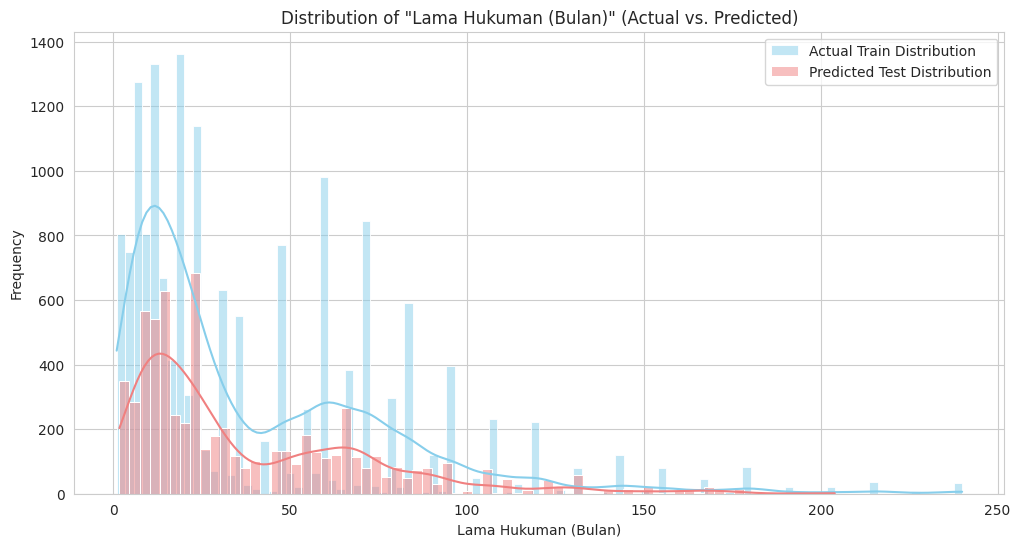

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))

# Plot the distribution of the actual 'lama hukuman (bulan)' in the training data
sns.histplot(train_df_fe['lama hukuman (bulan)'], kde=True, color='skyblue', label='Actual Train Distribution', bins=100)

# Plot the distribution of the predicted 'lama hukuman (bulan)' for the test data
sns.histplot(submission_df['lama hukuman (bulan)'], kde=True, color='lightcoral', label='Predicted Test Distribution', bins=71)

plt.title('Distribution of "Lama Hukuman (Bulan)" (Actual vs. Predicted)')
plt.xlabel('Lama Hukuman (Bulan)')
plt.ylabel('Frequency')
plt.legend()
plt.show()